#Setting up and Importing libs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 21.1 MB/s eta 0:00:00


In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.5 MB/s eta 0:00:00


In [ ]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.offline import init_notebook_mode
import plotly.graph_objects as go
init_notebook_mode(connected=True)
pd.set_option('display.max_columns', 5000)
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
import scipy
import scipy.stats as stats
import shap
from sklearn.model_selection import KFold

import optuna
from optuna.samplers import TPESampler

In [ ]:
pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.4 MB/s eta 0:00:00


In [ ]:
test_data = pd.read_csv('/content/drive/MyDrive/Data Science/Kaggle Competitions/Regression/test.csv')
train_data = pd.read_csv('/content/drive/MyDrive/Data Science/Kaggle Competitions/Regression/train.csv')
original = pd.read_csv('/content/drive/MyDrive/Data Science/Kaggle Competitions/Regression/used_cars.csv')
original

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$10,300"
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005"
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,"$54,598"
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,"$15,500"
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,"$34,999"
...,...,...,...,...,...,...,...,...,...,...,...,...
4004,Bentley,Continental GT Speed,2023,714 mi.,Gasoline,6.0L W12 48V PDI DOHC Twin Turbo,8-Speed Automatic with Auto-Shift,C / C,Hotspur,None reported,Yes,"$349,950"
4005,Audi,S4 3.0T Premium Plus,2022,"10,900 mi.",Gasoline,349.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,"$53,900"
4006,Porsche,Taycan,2022,"2,116 mi.",NaN,Electric,Automatic,Black,Black,None reported,NaN,"$90,998"
4007,Ford,F-150 Raptor,2020,"33,000 mi.",Gasoline,450.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,Blue,Black,None reported,Yes,"$62,999"


##Handle original

In [ ]:
for index, i in enumerate(original['price']):
  if i[0] == "$":
    original['price'].iloc[index] = original['price'].iloc[index].replace('$','')
    original['price'].iloc[index] = original['price'].iloc[index].replace(',','')
original

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,10300
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,38005
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,54598
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,15500
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,34999
...,...,...,...,...,...,...,...,...,...,...,...,...
4004,Bentley,Continental GT Speed,2023,714 mi.,Gasoline,6.0L W12 48V PDI DOHC Twin Turbo,8-Speed Automatic with Auto-Shift,C / C,Hotspur,None reported,Yes,349950
4005,Audi,S4 3.0T Premium Plus,2022,"10,900 mi.",Gasoline,349.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,53900
4006,Porsche,Taycan,2022,"2,116 mi.",NaN,Electric,Automatic,Black,Black,None reported,NaN,90998
4007,Ford,F-150 Raptor,2020,"33,000 mi.",Gasoline,450.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,Blue,Black,None reported,Yes,62999


In [ ]:
for index, i in enumerate(original['milage']):
  if i[-1] == ".":
    original['milage'].iloc[index] = original['milage'].iloc[index].replace('mi.','')
    original['milage'].iloc[index] = original['milage'].iloc[index].replace(',','')
original

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,51000,E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,10300
1,Hyundai,Palisade SEL,2021,34742,Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,38005
2,Lexus,RX 350 RX 350,2022,22372,Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,54598
3,INFINITI,Q50 Hybrid Sport,2015,88900,Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,15500
4,Audi,Q3 45 S line Premium Plus,2021,9835,Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,34999
...,...,...,...,...,...,...,...,...,...,...,...,...
4004,Bentley,Continental GT Speed,2023,714,Gasoline,6.0L W12 48V PDI DOHC Twin Turbo,8-Speed Automatic with Auto-Shift,C / C,Hotspur,None reported,Yes,349950
4005,Audi,S4 3.0T Premium Plus,2022,10900,Gasoline,349.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,53900
4006,Porsche,Taycan,2022,2116,NaN,Electric,Automatic,Black,Black,None reported,NaN,90998
4007,Ford,F-150 Raptor,2020,33000,Gasoline,450.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,Blue,Black,None reported,Yes,62999


In [ ]:
train_data = pd.concat([train_data.drop(['id'], axis=1), original],ignore_index=True)
train_data['milage'] = train_data['milage'].astype(int)
train_data['price'] = train_data['price'].astype(int)
train_data

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500
...,...,...,...,...,...,...,...,...,...,...,...,...
192537,Bentley,Continental GT Speed,2023,714,Gasoline,6.0L W12 48V PDI DOHC Twin Turbo,8-Speed Automatic with Auto-Shift,C / C,Hotspur,None reported,Yes,349950
192538,Audi,S4 3.0T Premium Plus,2022,10900,Gasoline,349.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,53900
192539,Porsche,Taycan,2022,2116,NaN,Electric,Automatic,Black,Black,None reported,NaN,90998
192540,Ford,F-150 Raptor,2020,33000,Gasoline,450.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,Blue,Black,None reported,Yes,62999


In [ ]:
pd.options.display.float_format = "{:.3f}".format

In [ ]:
train_data

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500
...,...,...,...,...,...,...,...,...,...,...,...,...
192537,Bentley,Continental GT Speed,2023,714,Gasoline,6.0L W12 48V PDI DOHC Twin Turbo,8-Speed Automatic with Auto-Shift,C / C,Hotspur,None reported,Yes,349950
192538,Audi,S4 3.0T Premium Plus,2022,10900,Gasoline,349.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,53900
192539,Porsche,Taycan,2022,2116,NaN,Electric,Automatic,Black,Black,None reported,NaN,90998
192540,Ford,F-150 Raptor,2020,33000,Gasoline,450.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,Blue,Black,None reported,Yes,62999


#EDA

##Unique Values

In [ ]:
for i in train_data.columns:
  print(f'{i} has {train_data[i].nunique()} unique items')

brand has 57 unique items
model has 1898 unique items
model_year has 34 unique items
milage has 6652 unique items
fuel_type has 7 unique items
engine has 1146 unique items
transmission has 62 unique items
ext_col has 319 unique items
int_col has 156 unique items
accident has 2 unique items
clean_title has 1 unique items
price has 1569 unique items


## Missing Values

In [ ]:
train_data.isna().sum()

,0
brand,0
model,0
model_year,0
milage,0
fuel_type,5253
engine,0
transmission,0
ext_col,0
int_col,0
accident,2565


In [ ]:
test_data.isna().sum()

,0
id,0
brand,0
model,0
model_year,0
milage,0
fuel_type,3383
engine,0
transmission,0
ext_col,0
int_col,0


Replaced Null values with "Null"

In [ ]:
# train_data.dropna(inplace=True)
train_data.fillna('Null', inplace=True)
test_data.fillna('Null',inplace=True)
train_data

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500
...,...,...,...,...,...,...,...,...,...,...,...,...
192537,Bentley,Continental GT Speed,2023,714,Gasoline,6.0L W12 48V PDI DOHC Twin Turbo,8-Speed Automatic with Auto-Shift,C / C,Hotspur,None reported,Yes,349950
192538,Audi,S4 3.0T Premium Plus,2022,10900,Gasoline,349.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,53900
192539,Porsche,Taycan,2022,2116,Null,Electric,Automatic,Black,Black,None reported,Null,90998
192540,Ford,F-150 Raptor,2020,33000,Gasoline,450.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,Blue,Black,None reported,Yes,62999


In [ ]:
def replacing_with_Null(feature):
  if feature == "–":
    return "Null"
  else:
    return feature
for i in train_data.columns:
  train_data[i] = train_data[i].apply(replacing_with_Null)
for i in test_data.columns:
  test_data[i] = test_data[i].apply(replacing_with_Null)


##Drop Duplicates

In [ ]:
train_data.drop_duplicates(inplace=True)
train_data

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500
...,...,...,...,...,...,...,...,...,...,...,...,...
192537,Bentley,Continental GT Speed,2023,714,Gasoline,6.0L W12 48V PDI DOHC Twin Turbo,8-Speed Automatic with Auto-Shift,C / C,Hotspur,None reported,Yes,349950
192538,Audi,S4 3.0T Premium Plus,2022,10900,Gasoline,349.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,53900
192539,Porsche,Taycan,2022,2116,Null,Electric,Automatic,Black,Black,None reported,Null,90998
192540,Ford,F-150 Raptor,2020,33000,Gasoline,450.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,Blue,Black,None reported,Yes,62999


##Analyzing columns and patching

In [ ]:
train_data.describe()

,model_year,milage,price
count,192542.000,192542.000,192542.000
mean,2015.823,65684.729,43892.074
std,5.671,49851.513,78817.111
min,1974.000,100.000,2000.000
25%,2013.000,24115.000,17000.000
50%,2017.000,57550.000,30825.000
75%,2020.000,95400.000,49900.000
max,2024.000,405000.000,2954083.000


### Column Model reformatted

In [ ]:
list_model = train_data['model'].unique()
actual_model = set()
for i in list_model:
  actual_model.add(i.lower())
print(len(actual_model))
train_data['model'].nunique()

1894


1898

In [ ]:
for i in range(len(list_model)):
    for j in range(i + 1, len(list_model)):
        if list_model[i].lower() == list_model[j].lower():
            print(f"Duplicate found: {list_model[i], list_model[j]}")

Duplicate found: ('F-250 Lariat', 'F-250 LARIAT')
Duplicate found: ('Impreza WRX Sti', 'Impreza WRX STI')
Duplicate found: ('RX 450h F Sport Handling', 'RX 450h F SPORT Handling')
Duplicate found: ('Explorer sport', 'Explorer Sport')


column 'model' has these hidden duplicates

In [ ]:
def uncapitalize(feature):
  return feature.lower()
train_data['model'] = train_data['model'].apply(uncapitalize)
train_data['model']

,model
0,cooper s base
1,ls v8
2,silverado 2500 lt
3,g90 5.0 ultimate
4,metris base
...,...
192537,continental gt speed
192538,s4 3.0t premium plus
192539,taycan
192540,f-150 raptor


In [ ]:
def uncapitalize(feature):
  return feature.lower()
test_data['model'] = test_data['model'].apply(uncapitalize)
test_data['model']

,model
0,rover lr2 base
1,rover defender se
2,expedition limited
3,a6 2.0t sport
4,a6 2.0t premium plus
...,...
125685,gl-class gl 450 4matic
125686,q7 55 prestige
125687,a6 3.0t premium plus
125688,q7 3.0t premium


### Column 'fuel' reformatted

In [ ]:
fuel = ['fuel_type', 'engine']
train_data[train_data['fuel_type'] == "Null"][fuel]

,fuel_type,engine
11,Null,Electric Motor Electric Fuel System
32,Null,518.0HP Electric Motor Electric Fuel System
51,Null,Dual Motor - Standard
52,Null,518.0HP Electric Motor Electric Fuel System
161,Null,670.0HP Electric Motor Electric Fuel System
...,...,...
192465,Null,778.0HP Electric Motor Electric Fuel System
192485,Null,Null
192494,Null,Electric
192517,Null,Null


In [ ]:
train_data['fuel_type'].unique()

array(['Gasoline', 'E85 Flex Fuel', 'Null', 'Hybrid', 'Diesel',
       'Plug-In Hybrid', 'not supported'], dtype=object)

**Changed not supported to null and change all null to keywords based on engines**

In [ ]:
train_data.loc[train_data['fuel_type'] == "not supported", 'fuel_type'] = 'Null'
test_data.loc[test_data['fuel_type'] == "not supported", 'fuel_type'] = 'Null'


In [ ]:
def electric(feature):
  feature_list = feature.split(' ')
  if "Electric" in feature_list or "Battery" in feature_list:
    return "Electric"
  else:
    return "Null"
def gasoline(feature):
  feature_list = feature.split(' ')
  if "Gasoline" in feature_list:
    return "Gasoline"
  else:
    return "Null"
def Tesla(feature):
  if feature == "Tesla":
    return "Electric"
  else:
    return "Null"
def Hybrid(feature):
  feature_list = feature.split(' ')
  if "Hybrid" in feature_list:
    return "Hybrid"
  else:
    return "Null"
def Flex_fuel(feature):
  if "Flex Fuel" in feature:
    return "E85 Flex Fuel"
  else:
    return "Null"
def Diesel(feature):
  feature_list = feature.split(' ')
  if "Diesel" in feature_list:
    return "Diesel"
  else:
    return "Null"
train_data.loc[train_data['fuel_type'] == "Null", 'fuel_type'] = train_data.loc[train_data['fuel_type'] == "Null", 'engine'].apply(electric)
train_data.loc[train_data['fuel_type'] == "Null", 'fuel_type'] = train_data.loc[train_data['fuel_type'] == "Null", 'engine'].apply(gasoline)
train_data.loc[train_data['fuel_type'] == "Null", 'fuel_type'] = train_data.loc[train_data['fuel_type'] == "Null", 'brand'].apply(Tesla)
train_data.loc[train_data['fuel_type'] == "Null", 'fuel_type'] = train_data.loc[train_data['fuel_type'] == "Null", 'engine'].apply(Hybrid)
train_data.loc[train_data['fuel_type'] == "Null", 'fuel_type'] = train_data.loc[train_data['fuel_type'] == "Null", 'engine'].apply(Flex_fuel)
train_data.loc[train_data['fuel_type'] == "Null", 'fuel_type'] = train_data.loc[train_data['fuel_type'] == "Null", 'engine'].apply(Diesel)

test_data.loc[test_data['fuel_type'] == "Null", 'fuel_type'] = test_data.loc[test_data['fuel_type'] == "Null", 'engine'].apply(electric)
test_data.loc[test_data['fuel_type'] == "Null", 'fuel_type'] = test_data.loc[test_data['fuel_type'] == "Null", 'engine'].apply(gasoline)
test_data.loc[test_data['fuel_type'] == "Null", 'fuel_type'] = test_data.loc[test_data['fuel_type'] == "Null", 'brand'].apply(Tesla)
test_data.loc[test_data['fuel_type'] == "Null", 'fuel_type'] = test_data.loc[test_data['fuel_type'] == "Null", 'engine'].apply(Hybrid)
test_data.loc[test_data['fuel_type'] == "Null", 'fuel_type'] = test_data.loc[test_data['fuel_type'] == "Null", 'engine'].apply(Flex_fuel)
test_data.loc[test_data['fuel_type'] == "Null", 'fuel_type'] = test_data.loc[test_data['fuel_type'] == "Null", 'engine'].apply(Diesel)


**One big issue is that the fuel type that are Null and - can't be determined with an automated system**

###Column "Transmission", "Ext_col", and "Int_col" reformatted

In [ ]:
list_model = train_data['transmission'].unique()
actual_model = set()
for i in list_model:
  actual_model.add(i.lower())
print(len(actual_model))
train_data['transmission'].nunique()

61


62

**Another hidden duplicates**

In [ ]:
train_data['transmission'] = train_data['transmission'].apply(uncapitalize)
train_data['transmission']

,transmission
0,a/t
1,a/t
2,a/t
3,transmission w/dual shift mode
4,7-speed a/t
...,...
192537,8-speed automatic with auto-shift
192538,transmission w/dual shift mode
192539,automatic
192540,a/t


In [ ]:
test_data['transmission'] = test_data['transmission'].apply(uncapitalize)
test_data['transmission']

,transmission
0,6-speed a/t
1,8-speed a/t
2,10-speed automatic
3,automatic
4,a/t
...,...
125685,7-speed a/t
125686,automatic
125687,a/t
125688,a/t


In [ ]:
list_model = train_data['ext_col'].unique()
actual_model = set()
for i in list_model:
  actual_model.add(i.lower())
print(len(actual_model))
train_data['ext_col'].nunique()

317


319

In [ ]:
train_data['ext_col'] = train_data['ext_col'].apply(uncapitalize)
train_data['ext_col']

,ext_col
0,yellow
1,silver
2,blue
3,black
4,black
...,...
192537,c / c
192538,black
192539,black
192540,blue


In [ ]:
test_data['ext_col'] = test_data['ext_col'].apply(uncapitalize)
test_data['ext_col']

,ext_col
0,white
1,silver
2,white
3,silician yellow
4,gray
...,...
125685,black
125686,white
125687,black
125688,black


In [ ]:
list_model = train_data['int_col'].unique()
actual_model = set()
for i in list_model:
  actual_model.add(i.lower())
print(len(actual_model))
train_data['int_col'].nunique()

152


156

In [ ]:
train_data['int_col'] = train_data['int_col'].apply(uncapitalize)
train_data['int_col']

,int_col
0,gray
1,beige
2,gray
3,black
4,beige
...,...
192537,hotspur
192538,black
192539,black
192540,black


In [ ]:
test_data['int_col'] = test_data['int_col'].apply(uncapitalize)
test_data['int_col']

,int_col
0,beige
1,black
2,ebony
3,black
4,black
...,...
125685,black
125686,black
125687,black
125688,black


In [ ]:
def categorize_color(count, common_threshold, rare_threshold):
    if count >= common_threshold:
        return 'common'
    elif count <= rare_threshold:
        return 'rare'
    else:
        return 'less common'

# Function to categorize colors based on their frequency, with threshold calculation inside the function
def categorize_column(train_df, test_df, column):
    # Calculate value counts for the given column
    value_counts = train_df[column].value_counts()

    # Define thresholds based on quantiles (75% for common, 25% for rare)
    common_threshold = value_counts.quantile(0.75)
    rare_threshold = value_counts.quantile(0.25)

    # Apply categorization to train and test data
    train_df[column] = train_df[column].map(lambda x: categorize_color(value_counts[x], common_threshold, rare_threshold))
    test_df[column] = test_df[column].map(lambda x: categorize_color(value_counts.get(x, 0), common_threshold, rare_threshold))

    return train_df, test_df

# Apply categorization to the columns
train_data, test_data = categorize_column(train_data, test_data, 'int_col')
train_data, test_data = categorize_column(train_data, test_data, 'ext_col')

In [ ]:
train_data

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,MINI,cooper s base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,a/t,common,common,None reported,Yes,4200
1,Lincoln,ls v8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,a/t,common,common,At least 1 accident or damage reported,Yes,4999
2,Chevrolet,silverado 2500 lt,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,a/t,common,common,None reported,Yes,13900
3,Genesis,g90 5.0 ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,transmission w/dual shift mode,common,common,None reported,Yes,45000
4,Mercedes-Benz,metris base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-speed a/t,common,common,None reported,Yes,97500
...,...,...,...,...,...,...,...,...,...,...,...,...
192537,Bentley,continental gt speed,2023,714,Gasoline,6.0L W12 48V PDI DOHC Twin Turbo,8-speed automatic with auto-shift,less common,less common,None reported,Yes,349950
192538,Audi,s4 3.0t premium plus,2022,10900,Gasoline,349.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,transmission w/dual shift mode,common,common,None reported,Yes,53900
192539,Porsche,taycan,2022,2116,Electric,Electric,automatic,common,common,None reported,Null,90998
192540,Ford,f-150 raptor,2020,33000,Gasoline,450.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,a/t,common,common,None reported,Yes,62999


In [ ]:
test_data

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,188533,Land,rover lr2 base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-speed a/t,common,common,None reported,Yes
1,188534,Land,rover defender se,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-speed a/t,common,common,None reported,Yes
2,188535,Ford,expedition limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-speed automatic,common,common,None reported,Null
3,188536,Audi,a6 2.0t sport,2016,61258,Gasoline,2.0 Liter TFSI,automatic,rare,common,None reported,Null
4,188537,Audi,a6 2.0t premium plus,2018,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,a/t,common,common,None reported,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...
125685,314218,Mercedes-Benz,gl-class gl 450 4matic,2014,83315,Gasoline,362.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,7-speed a/t,common,common,None reported,Yes
125686,314219,Audi,q7 55 prestige,2019,29336,Gasoline,3.0 Liter Turbo,automatic,common,common,None reported,Null
125687,314220,Audi,a6 3.0t premium plus,2012,77634,Gasoline,333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,a/t,common,common,None reported,Yes
125688,314221,Audi,q7 3.0t premium,2012,112000,Gasoline,333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,a/t,common,common,None reported,Yes


###Label Encode

**Data type for each column**

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192542 entries, 0 to 192541
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   brand         192542 non-null  object
 1   model         192542 non-null  object
 2   model_year    192542 non-null  int64 
 3   milage        192542 non-null  int64 
 4   fuel_type     192542 non-null  object
 5   engine        192542 non-null  object
 6   transmission  192542 non-null  object
 7   ext_col       192542 non-null  object
 8   int_col       192542 non-null  object
 9   accident      192542 non-null  object
 10  clean_title   192542 non-null  object
 11  price         192542 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 17.6+ MB


handling categorical data

In [ ]:
from sklearn.preprocessing import LabelEncoder
categorical_col = ['brand', 'model', 'fuel_type','engine','transmission','ext_col','int_col','accident','clean_title']
label_encoder = LabelEncoder()
for i in categorical_col:
  train_data[i] = label_encoder.fit_transform(train_data[i])
train_data[categorical_col]

,brand,model,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,31,461,3,117,37,0,0,1,1
1,28,962,3,370,37,0,0,0,1
2,9,1557,1,653,37,0,0,1,1
3,16,762,3,878,59,0,0,1,1
4,36,1064,3,263,23,0,0,1,1
...,...,...,...,...,...,...,...,...,...
192537,5,450,3,1060,32,1,1,1,1
192538,3,1471,3,714,59,0,0,1,1
192539,43,1658,2,1133,39,0,0,1,0
192540,14,671,3,917,37,0,0,1,1


In [ ]:
categorical_col = ['brand', 'model', 'fuel_type','engine','transmission','ext_col','int_col','accident','clean_title']
for i in categorical_col:
  test_data[i] = label_encoder.fit_transform(test_data[i])
test_data[categorical_col]

,brand,model,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,26,1365,3,326,16,0,0,1,1
1,26,1352,4,787,29,0,0,1,1
2,14,642,3,541,3,0,0,1,0
3,3,182,3,193,38,2,0,1,0
4,3,181,3,365,37,0,0,1,1
...,...,...,...,...,...,...,...,...,...
125685,36,782,3,732,23,0,0,1,1
125686,3,1255,3,511,38,0,0,1,0
125687,3,184,3,673,37,0,0,1,1
125688,3,1251,3,673,37,0,0,1,1


###Analysis

**Distribution of target column**

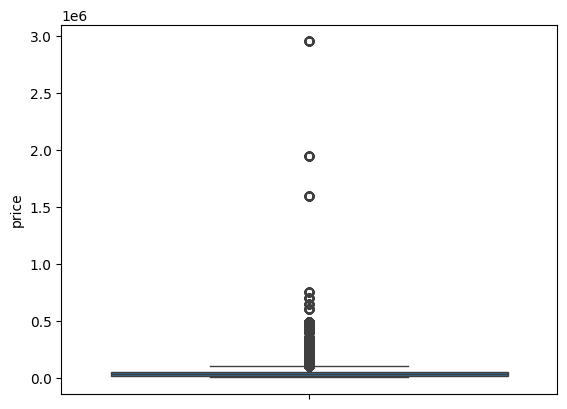

In [ ]:
sns.boxplot(train_data['price'])

# Show the plot
plt.show()

should use minmaxscaler

**Distribution and Boxplot for numerical variables**


In [ ]:
X = train_data.drop(columns='price')
X

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,31,461,2007,213000,3,117,37,0,0,1,1
1,28,962,2002,143250,3,370,37,0,0,0,1
2,9,1557,2002,136731,1,653,37,0,0,1,1
3,16,762,2017,19500,3,878,59,0,0,1,1
4,36,1064,2021,7388,3,263,23,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
192537,5,450,2023,714,3,1060,32,1,1,1,1
192538,3,1471,2022,10900,3,714,59,0,0,1,1
192539,43,1658,2022,2116,2,1133,39,0,0,1,0
192540,14,671,2020,33000,3,917,37,0,0,1,1


Text(0.5, 0.98, 'Visualizing Continuous Columns')

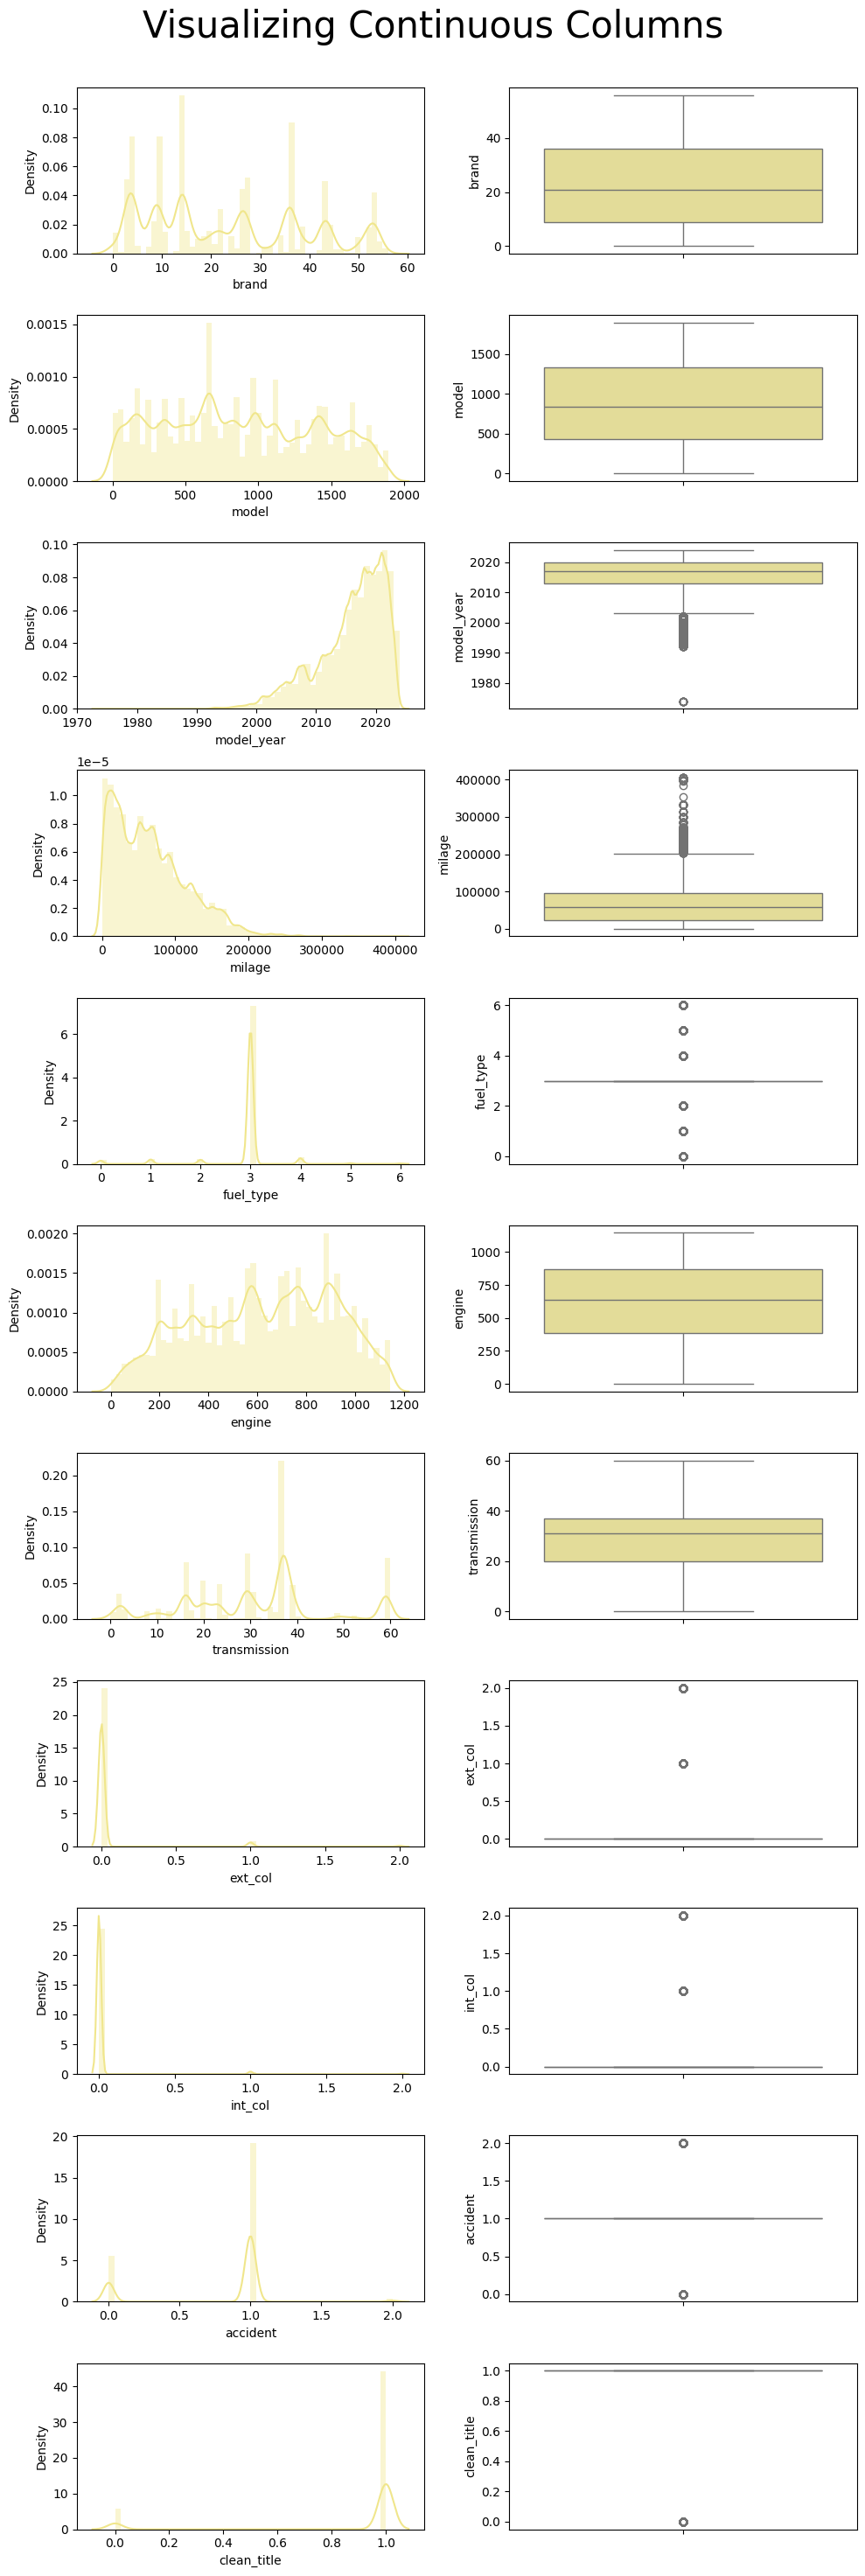

In [ ]:
fig, ax = plt.subplots(11,2,figsize=(10,30))
for index, i in enumerate(X.columns):
    sns.distplot(X[i],ax=ax[index,0], color = 'khaki')
    sns.boxplot(X[i],ax=ax[index,1], color = 'khaki')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.suptitle("Visualizing Continuous Columns",fontsize=30)

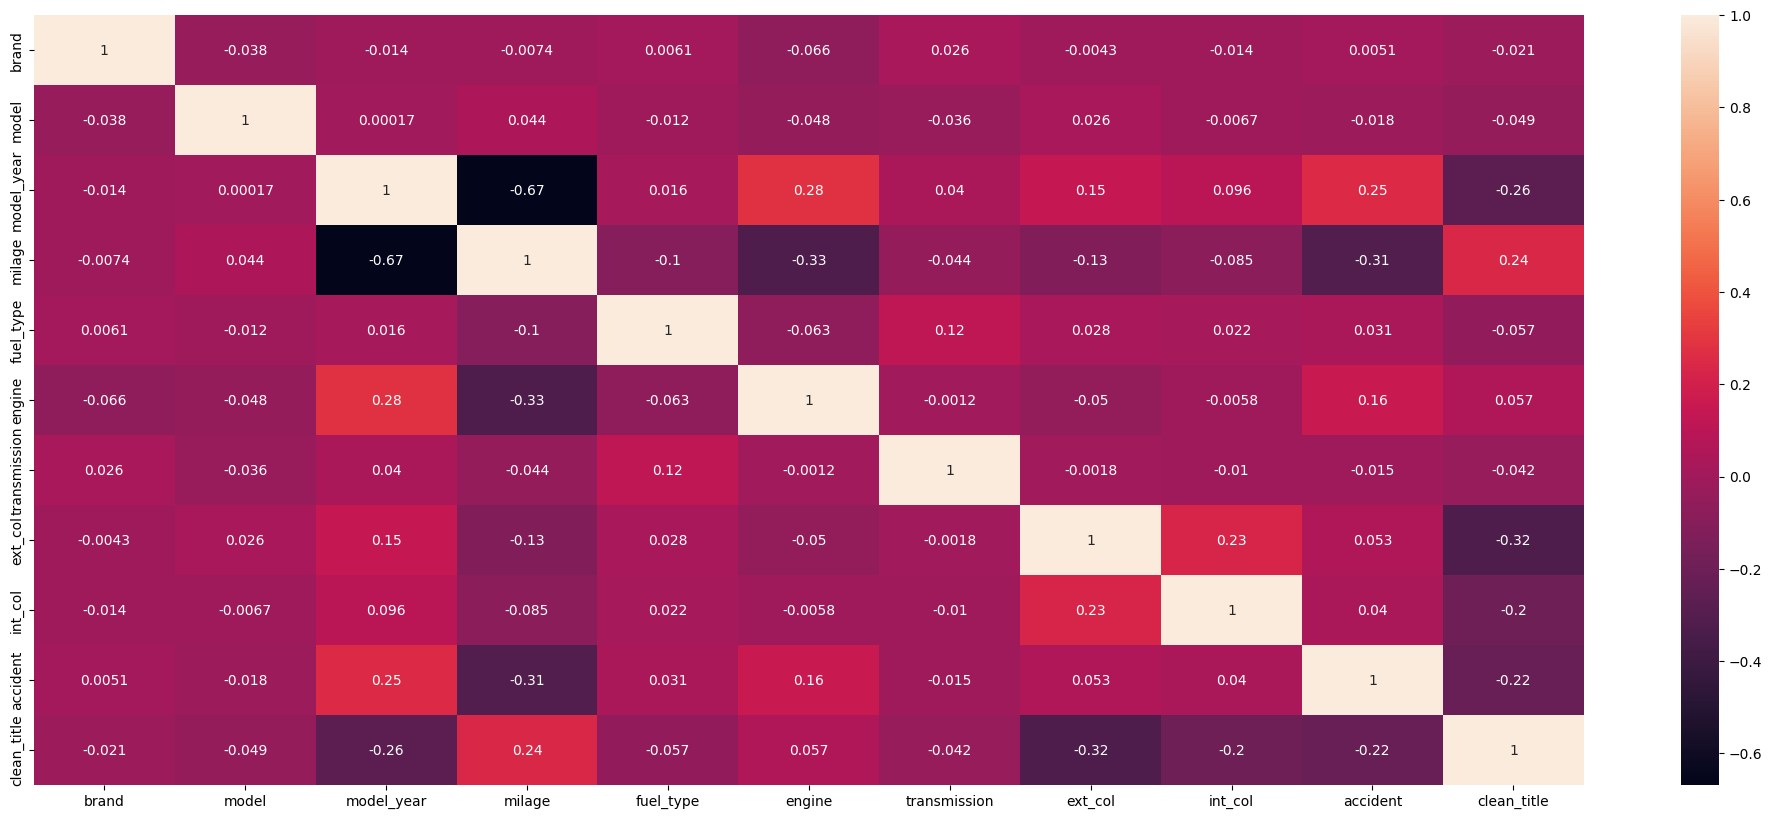

In [ ]:
plt.figure(figsize=(25,10))
sns.heatmap(X.corr(),annot=True)
plt.show()

Mutual Info

In [ ]:
from sklearn.feature_selection import mutual_info_regression

y_sampled = train_data['price']
mutual_df = train_data.drop(['price'], axis=1)

mutual_info = mutual_info_regression(mutual_df, y_sampled, random_state=42)

mutual_info = pd.Series(mutual_info)
mutual_info.index = mutual_df.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["Numerical_Feature_MI"] )
mutual_info.style.background_gradient("cool")

,Numerical_Feature_MI
milage,0.680760
engine,0.615807
model_year,0.544440
transmission,0.442709
model,0.433406
clean_title,0.158834
brand,0.155247
accident,0.063006
ext_col,0.043027
fuel_type,0.031547


#Data Preprocessing

##Feature engineering and selection

**none**

In [ ]:
# train_data

##Splitting into Training/Validation/Test

In [ ]:
# Y = train_data['price']
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25,random_state=42)


Balance dataset can be split randomly but since the distribution of the target is imbalanced, its better to use stratified Kfold to split the training/validation sets

##Normalization/Standardization

In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# # Create a MinMaxScaler object
# scaler = MinMaxScaler()

# # Fit and transform the data
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [ ]:
# X_test

#Modeling

##Finding a baseline model

In [ ]:
from sklearn.linear_model import LinearRegression , ElasticNet , Lasso , Ridge
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict

In [ ]:
lgbm = LGBMRegressor()
random = RandomForestRegressor()
linear = LinearRegression()
ridge = Ridge()
svr=SVR()
gbr = GradientBoostingRegressor()
bay = BayesianRidge()
lr = LogisticRegression()
xgb1 = XGBRegressor()
cb = CatBoostRegressor()


In [ ]:
X = train_data.drop(columns=["price"])
Y = train_data["price"]
# X, X_test, Y, Y_test = train_test_split(X, Y, test_size=0.25,random_state=42)

test_data = test_data.drop(columns=["id"])
test_data

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,26,1365,2015,98000,3,326,16,0,0,1,1
1,26,1352,2020,9142,4,787,29,0,0,1,1
2,14,642,2022,28121,3,541,3,0,0,1,0
3,3,182,2016,61258,3,193,38,2,0,1,0
4,3,181,2018,59000,3,365,37,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
125685,36,782,2014,83315,3,732,23,0,0,1,1
125686,3,1255,2019,29336,3,511,38,0,0,1,0
125687,3,184,2012,77634,3,673,37,0,0,1,1
125688,3,1251,2012,112000,3,673,37,0,0,1,1


In [ ]:
from statistics import mean, stdev
cv = KFold(n_splits= 5, shuffle=True, random_state=42)

def compute(model):
    lst_accu_stratified = []
    lst_rmse_stratified = []
    fold = 1
    for train_index, test_index in cv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
        model.fit(X_train, Y_train)
        preds = model.predict(X_test)

        rmse = np.sqrt(mean_squared_error(Y_test, preds, squared=True))
        r2 = r2_score(Y_test, preds)
        print(f"Fold {fold}: RMSE = {rmse:.4f}, R2 = {r2:.4f}")

        print("\n" + "=" * 75 + "\n")
        lst_accu_stratified.append(r2)
        lst_rmse_stratified.append(rmse)
        fold +=1

    mean_rmse = mean(lst_rmse_stratified)
    max_rmse = max(lst_rmse_stratified)
    min_rmse = min(lst_rmse_stratified)
    max_val_score = max(lst_accu_stratified)
    min_val_score = min(lst_accu_stratified)
    mean_val_score = mean(lst_accu_stratified)
    std = stdev(lst_accu_stratified)

    hashmap[str(model)]=([mean_rmse, max_rmse, min_rmse, mean_val_score, max_val_score, min_val_score, std])

In [ ]:
clf = [gbr,lgbm,xgb1,cb]
hashmap={}
for i in clf:
    compute(i)

Streaming output truncated to the last 5000 lines.
24:	learn: 72617.2600641	total: 428ms	remaining: 16.7s
25:	learn: 72584.2619296	total: 443ms	remaining: 16.6s
26:	learn: 72550.4115132	total: 458ms	remaining: 16.5s
27:	learn: 72516.2489987	total: 471ms	remaining: 16.4s
28:	learn: 72463.4792804	total: 485ms	remaining: 16.2s
29:	learn: 72430.4638285	total: 500ms	remaining: 16.2s
30:	learn: 72395.9903754	total: 516ms	remaining: 16.1s
31:	learn: 72370.8085700	total: 529ms	remaining: 16s
32:	learn: 72330.8903107	total: 546ms	remaining: 16s
33:	learn: 72293.7063092	total: 559ms	remaining: 15.9s
34:	learn: 72254.6343196	total: 574ms	remaining: 15.8s
35:	learn: 72230.5736379	total: 597ms	remaining: 16s
36:	learn: 72173.0562678	total: 612ms	remaining: 15.9s
37:	learn: 72150.7630649	total: 625ms	remaining: 15.8s
38:	learn: 72124.4053116	total: 639ms	remaining: 15.7s
39:	learn: 72087.6551549	total: 652ms	remaining: 15.6s
40:	learn: 72071.8982579	total: 670ms	remaining: 15.7s
41:	learn: 72040.941

In [ ]:
score=pd.DataFrame(hashmap)
score = score.transpose()
score.columns=['Mean_RMSE','Max_rmse','Min_rmse','Mean_R2','Max_R2',"Min_R2",'STD']
score = score.sort_values('Mean_RMSE',ascending=True)
score

,Mean_RMSE,Max_rmse,Min_rmse,Mean_R2,Max_R2,Min_R2,STD
LGBMRegressor(),72731.639,75558.464,68153.430,0.148,0.162,0.138,0.011
GradientBoostingRegressor(),72792.838,75633.525,68225.986,0.146,0.160,0.133,0.013
<catboost.core.CatBoostRegressor object at 0x7952c23bca60>,73626.886,76799.380,69568.980,0.126,0.133,0.113,0.008
"XGBRegressor(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, device=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n gamma=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=None, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None, max_leaves=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n multi_strategy=None, n_estimators=None, n_jobs=None,\n num_parallel_tree=None, random_state=None, ...)",75121.290,78324.511,71451.973,0.090,0.106,0.077,0.012


## Feature Importance

In [ ]:
from matplotlib import pyplot

def checking_feature_imp(model):
  for i,v in enumerate (model.feature_importances_):
    print(f'{X.columns[i]}: {v: 5f}')
  pyplot.bar([x for x in range(1, len(model.feature_importances_)+1)], model.feature_importances_)
  pyplot.show()

In [ ]:
well_performed_clf = [gbr,lgbm,xgb1,cb]
for each_clf in well_performed_clf:
  print(each_clf)
  checking_feature_imp(each_clf)
  print()

Rework feature engineering and possibly normalizing

In [ ]:
# X = X.drop(columns=["fuel_type"])

# test_data = test_data.drop(columns=['fuel_type'])

##Tuning Baseline Model

In [ ]:
def tune(model):
  lst_rmse = []
  lst_r2 = []
  for train_index, test_index in cv.split(X):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
      model.fit(X_train, Y_train, eval_set=[(X_test, Y_test)],  callbacks=[early_stopping(stopping_rounds=50, verbose=False)])
      preds = model.predict(X_test)
      rmse = mean_squared_error(Y_test, preds, squared=False)
      r2 = r2_score(Y_test, preds)
      lst_rmse.append(rmse)
      lst_r2.append(r2)

  mean_rmse_score = mean(lst_rmse)
  mean_r2_score = mean(lst_r2)

  return mean_rmse_score, mean_r2_score, model

###LGBM

In [ ]:
from statistics import mean, stdev
from lightgbm import log_evaluation, early_stopping
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

# Define RMSE scorer
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
    }

    # Create LightGBM Regressor model
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []
    model = LGBMRegressor(**param)

    # Cross-validation loop
    for fold, (train_ind, valid_ind) in enumerate(cv.split(X)):
        # Data splitting
        X_fold_train = X.iloc[train_ind]
        y_fold_train = Y.iloc[train_ind]
        X_val = X.iloc[valid_ind]
        y_val = Y.iloc[valid_ind]

        model.fit(X_fold_train, y_fold_train,  eval_set=[(X_val, y_val)], callbacks=[early_stopping(stopping_rounds=200)])

        # Predict and evaluate
        preds = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        rmse_scores.append(rmse)

    return mean(rmse_scores)

# Create an Optuna study object
study = optuna.create_study(direction='minimize')  # Minimize RMSE
study.optimize(objective, n_trials=100)

best_trial = study.best_trials
print(f"Best hyperparameters: {study.best_params}")
print(f"Best RMSE: {study.best_value:.4f}")

[I 2024-09-19 08:13:16,099] A new study created in memory with name: no-name-7dea0fe0-8696-48d4-92fe-ebc1f85a376f


Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[135]	valid_0's rmse: 75183.1
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[178]	valid_0's rmse: 67864.4
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[125]	valid_0's rmse: 69493.2
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[195]	valid_0's rmse: 74840.5
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[181]	valid_0's rmse: 75348.2


[I 2024-09-19 08:13:57,051] Trial 0 finished with value: 72545.86737560599 and parameters: {'n_estimators': 352, 'learning_rate': 0.031598096636149396, 'num_leaves': 80, 'max_depth': 17, 'min_child_samples': 77, 'subsample': 0.5444541254961008, 'colsample_bytree': 0.8420245668264943, 'reg_alpha': 0.2602957674299268, 'reg_lambda': 0.28749942471657464}. Best is trial 0 with value: 72545.86737560599.


mean rmse: 72545.86737560599
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[198]	valid_0's rmse: 75237.7
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[165]	valid_0's rmse: 67926.7
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[161]	valid_0's rmse: 69543.9
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[216]	valid_0's rmse: 74925.9
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[181]	valid_0's rmse: 75369.7


[I 2024-09-19 08:14:41,456] Trial 1 finished with value: 72600.79273302208 and parameters: {'n_estimators': 495, 'learning_rate': 0.0261442450134774, 'num_leaves': 104, 'max_depth': 24, 'min_child_samples': 81, 'subsample': 0.9471939396942576, 'colsample_bytree': 0.9399175401239199, 'reg_alpha': 0.03736322579426823, 'reg_lambda': 0.1107564204343914}. Best is trial 0 with value: 72545.86737560599.


mean rmse: 72600.79273302208
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[273]	valid_0's rmse: 75211.8
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[273]	valid_0's rmse: 67989.5
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[273]	valid_0's rmse: 69554.1
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[273]	valid_0's rmse: 75021.8
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[273]	valid_0's rmse: 75448.6


[I 2024-09-19 08:15:37,286] Trial 2 finished with value: 72645.13842726791 and parameters: {'n_estimators': 273, 'learning_rate': 0.00867736587791423, 'num_leaves': 100, 'max_depth': 42, 'min_child_samples': 69, 'subsample': 0.8877804275625935, 'colsample_bytree': 0.579273369961347, 'reg_alpha': 0.004383946147551491, 'reg_lambda': 0.0022451359173431902}. Best is trial 0 with value: 72545.86737560599.


mean rmse: 72645.13842726791
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[292]	valid_0's rmse: 78180.3
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[292]	valid_0's rmse: 71403.3
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[292]	valid_0's rmse: 72843.6
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[292]	valid_0's rmse: 78165.8
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[292]	valid_0's rmse: 78708.3


[I 2024-09-19 08:16:27,110] Trial 3 finished with value: 75860.29250793159 and parameters: {'n_estimators': 292, 'learning_rate': 0.0013841473605012862, 'num_leaves': 70, 'max_depth': 37, 'min_child_samples': 87, 'subsample': 0.9458395947082223, 'colsample_bytree': 0.6441584390771808, 'reg_alpha': 0.011092083479065906, 'reg_lambda': 3.579731647907369}. Best is trial 0 with value: 72545.86737560599.


mean rmse: 75860.29250793159
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[60]	valid_0's rmse: 75105.2
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[89]	valid_0's rmse: 67814.1
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[49]	valid_0's rmse: 69398.5
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[110]	valid_0's rmse: 74833.5
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[65]	valid_0's rmse: 75204


[I 2024-09-19 08:16:49,119] Trial 4 finished with value: 72471.06581692449 and parameters: {'n_estimators': 206, 'learning_rate': 0.08726005082877493, 'num_leaves': 48, 'max_depth': 41, 'min_child_samples': 99, 'subsample': 0.7414096032452375, 'colsample_bytree': 0.5328025921002415, 'reg_alpha': 0.0011373918754394037, 'reg_lambda': 0.8310335527752326}. Best is trial 4 with value: 72471.06581692449.


mean rmse: 72471.06581692449
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[329]	valid_0's rmse: 75195
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[329]	valid_0's rmse: 67989
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[329]	valid_0's rmse: 69492.6
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[329]	valid_0's rmse: 74971.3
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[329]	valid_0's rmse: 75415.4


[I 2024-09-19 08:17:31,609] Trial 5 finished with value: 72612.66051358815 and parameters: {'n_estimators': 329, 'learning_rate': 0.008185326577756136, 'num_leaves': 67, 'max_depth': 46, 'min_child_samples': 82, 'subsample': 0.6064781075223384, 'colsample_bytree': 0.534134138555094, 'reg_alpha': 0.008163914856031095, 'reg_lambda': 0.043377361228425795}. Best is trial 4 with value: 72471.06581692449.


mean rmse: 72612.66051358815
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[101]	valid_0's rmse: 76581
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[101]	valid_0's rmse: 69671.8
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[101]	valid_0's rmse: 71097.9
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[101]	valid_0's rmse: 76582.4
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[101]	valid_0's rmse: 77170.7


[I 2024-09-19 08:17:52,305] Trial 6 finished with value: 74220.75661355961 and parameters: {'n_estimators': 101, 'learning_rate': 0.009926778675449907, 'num_leaves': 57, 'max_depth': 5, 'min_child_samples': 76, 'subsample': 0.7108953141754569, 'colsample_bytree': 0.6668522343067083, 'reg_alpha': 0.0010061172002497057, 'reg_lambda': 0.892030482122659}. Best is trial 4 with value: 72471.06581692449.


mean rmse: 74220.75661355961
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[473]	valid_0's rmse: 75936.7
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[473]	valid_0's rmse: 68885.5
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[473]	valid_0's rmse: 70319.7
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[473]	valid_0's rmse: 75806.1
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[473]	valid_0's rmse: 76340.2


[I 2024-09-19 08:18:43,621] Trial 7 finished with value: 73457.61430527475 and parameters: {'n_estimators': 473, 'learning_rate': 0.002756760121404858, 'num_leaves': 43, 'max_depth': 44, 'min_child_samples': 91, 'subsample': 0.6321806917876389, 'colsample_bytree': 0.5914177517768822, 'reg_alpha': 1.79053194702768, 'reg_lambda': 1.7960778094479484}. Best is trial 4 with value: 72471.06581692449.


mean rmse: 73457.61430527475
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[186]	valid_0's rmse: 75068.9
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[251]	valid_0's rmse: 67769.3
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[190]	valid_0's rmse: 69460.6
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[241]	valid_0's rmse: 74817.6
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[230]	valid_0's rmse: 75229.2


[I 2024-09-19 08:19:11,399] Trial 8 finished with value: 72469.11936377031 and parameters: {'n_estimators': 252, 'learning_rate': 0.022839800488060957, 'num_leaves': 70, 'max_depth': 47, 'min_child_samples': 71, 'subsample': 0.8851398872167814, 'colsample_bytree': 0.5488096876404042, 'reg_alpha': 5.86337044671729, 'reg_lambda': 1.6323916932781193}. Best is trial 8 with value: 72469.11936377031.


mean rmse: 72469.11936377031
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[252]	valid_0's rmse: 75078.7
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[268]	valid_0's rmse: 67780.3
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[189]	valid_0's rmse: 69458
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[246]	valid_0's rmse: 74844.5
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[208]	valid_0's rmse: 75255.6


[I 2024-09-19 08:19:40,982] Trial 9 finished with value: 72483.4325083178 and parameters: {'n_estimators': 273, 'learning_rate': 0.021911906911842048, 'num_leaves': 70, 'max_depth': 30, 'min_child_samples': 62, 'subsample': 0.8656148999888453, 'colsample_bytree': 0.5527997981034058, 'reg_alpha': 2.2820890271274186, 'reg_lambda': 0.02894494661078148}. Best is trial 8 with value: 72469.11936377031.


mean rmse: 72483.4325083178
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[37]	valid_0's rmse: 75174.2
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[38]	valid_0's rmse: 67929
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[34]	valid_0's rmse: 69704
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[34]	valid_0's rmse: 75096.7
Training until validation scores don't improve for 200 rounds


[I 2024-09-19 08:19:58,969] Trial 10 finished with value: 72669.954516034 and parameters: {'n_estimators': 166, 'learning_rate': 0.08027842050408343, 'num_leaves': 149, 'max_depth': 32, 'min_child_samples': 33, 'subsample': 0.824214679984451, 'colsample_bytree': 0.7561362237309799, 'reg_alpha': 0.1770835007771796, 'reg_lambda': 0.003689551648691178}. Best is trial 8 with value: 72469.11936377031.


Did not meet early stopping. Best iteration is:
[37]	valid_0's rmse: 75445.9
mean rmse: 72669.954516034
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[109]	valid_0's rmse: 75084.8
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[166]	valid_0's rmse: 67842.1
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[112]	valid_0's rmse: 69440.5
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[161]	valid_0's rmse: 74755.6
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[122]	valid_0's rmse: 75317.5


[I 2024-09-19 08:20:12,911] Trial 11 finished with value: 72488.08785865859 and parameters: {'n_estimators': 189, 'learning_rate': 0.09505029599486468, 'num_leaves': 23, 'max_depth': 49, 'min_child_samples': 100, 'subsample': 0.7733991551258557, 'colsample_bytree': 0.7207303405620809, 'reg_alpha': 8.96752846257366, 'reg_lambda': 8.547469651820125}. Best is trial 8 with value: 72469.11936377031.


mean rmse: 72488.08785865859
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[162]	valid_0's rmse: 74979.6
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[144]	valid_0's rmse: 67823.1
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's rmse: 69454.8
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[112]	valid_0's rmse: 74900.7
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[206]	valid_0's rmse: 75272.3


[I 2024-09-19 08:20:30,282] Trial 12 finished with value: 72486.11728607773 and parameters: {'n_estimators': 210, 'learning_rate': 0.0526597394465487, 'num_leaves': 36, 'max_depth': 37, 'min_child_samples': 47, 'subsample': 0.7209727242617017, 'colsample_bytree': 0.5031744080899094, 'reg_alpha': 1.3302044906611785, 'reg_lambda': 0.6406814826505502}. Best is trial 8 with value: 72469.11936377031.


mean rmse: 72486.11728607773
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[191]	valid_0's rmse: 75063.9
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[183]	valid_0's rmse: 68085
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[153]	valid_0's rmse: 69844.2
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[148]	valid_0's rmse: 75416.8
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[177]	valid_0's rmse: 75637.9


[I 2024-09-19 08:21:08,307] Trial 13 finished with value: 72809.54568849466 and parameters: {'n_estimators': 388, 'learning_rate': 0.017858688364125436, 'num_leaves': 102, 'max_depth': 41, 'min_child_samples': 5, 'subsample': 0.9941114930034526, 'colsample_bytree': 0.6466125317061268, 'reg_alpha': 0.05313340500325925, 'reg_lambda': 0.18909251133069382}. Best is trial 8 with value: 72469.11936377031.


mean rmse: 72809.54568849466
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's rmse: 75170.6
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[166]	valid_0's rmse: 67805.1
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[83]	valid_0's rmse: 69507.8
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[141]	valid_0's rmse: 74873.9
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[125]	valid_0's rmse: 75262.8


[I 2024-09-19 08:21:27,762] Trial 14 finished with value: 72524.03492393614 and parameters: {'n_estimators': 228, 'learning_rate': 0.04893541887310663, 'num_leaves': 48, 'max_depth': 50, 'min_child_samples': 50, 'subsample': 0.7956550494451544, 'colsample_bytree': 0.7959822706073653, 'reg_alpha': 0.0013451238353189982, 'reg_lambda': 8.467484871868614}. Best is trial 8 with value: 72469.11936377031.


mean rmse: 72524.03492393614
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[130]	valid_0's rmse: 76863
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[130]	valid_0's rmse: 69894.2
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[130]	valid_0's rmse: 71358.4
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[130]	valid_0's rmse: 76713.5
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[130]	valid_0's rmse: 77268.8


[I 2024-09-19 08:21:49,790] Trial 15 finished with value: 74419.58280648687 and parameters: {'n_estimators': 130, 'learning_rate': 0.0053151504610827556, 'num_leaves': 131, 'max_depth': 22, 'min_child_samples': 99, 'subsample': 0.6436959924250157, 'colsample_bytree': 0.9988489357267916, 'reg_alpha': 0.6324935598915671, 'reg_lambda': 1.9107065520097672}. Best is trial 8 with value: 72469.11936377031.


mean rmse: 74419.58280648687
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[134]	valid_0's rmse: 75082.9
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[207]	valid_0's rmse: 67822.6
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[163]	valid_0's rmse: 69544.8
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[205]	valid_0's rmse: 74921.5
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[208]	valid_0's rmse: 75348.9


[I 2024-09-19 08:22:06,972] Trial 16 finished with value: 72544.14091100803 and parameters: {'n_estimators': 235, 'learning_rate': 0.047594078261842414, 'num_leaves': 25, 'max_depth': 36, 'min_child_samples': 30, 'subsample': 0.6981597839695722, 'colsample_bytree': 0.5991217117086982, 'reg_alpha': 5.5211222164754075, 'reg_lambda': 0.46629971923533736}. Best is trial 8 with value: 72469.11936377031.


mean rmse: 72544.14091100803
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's rmse: 75107
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[295]	valid_0's rmse: 67855.3
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[228]	valid_0's rmse: 69573.4
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[290]	valid_0's rmse: 74907.6
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[294]	valid_0's rmse: 75307.8


[I 2024-09-19 08:22:54,222] Trial 17 finished with value: 72550.21009860968 and parameters: {'n_estimators': 397, 'learning_rate': 0.01614287059350595, 'num_leaves': 94, 'max_depth': 13, 'min_child_samples': 61, 'subsample': 0.8547476257063034, 'colsample_bytree': 0.6949744035550274, 'reg_alpha': 0.0366251034547703, 'reg_lambda': 0.026956253266177094}. Best is trial 8 with value: 72469.11936377031.


mean rmse: 72550.21009860968
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[162]	valid_0's rmse: 77494.6
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[162]	valid_0's rmse: 70664
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[162]	valid_0's rmse: 72092.5
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[162]	valid_0's rmse: 77465
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[162]	valid_0's rmse: 78006.4


[I 2024-09-19 08:23:16,912] Trial 18 finished with value: 75144.51613064785 and parameters: {'n_estimators': 162, 'learning_rate': 0.0033963844455591444, 'num_leaves': 116, 'max_depth': 40, 'min_child_samples': 35, 'subsample': 0.5153157117179525, 'colsample_bytree': 0.5053991610368818, 'reg_alpha': 0.27293680289091954, 'reg_lambda': 0.008849442495421654}. Best is trial 8 with value: 72469.11936377031.


mean rmse: 75144.51613064785
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[119]	valid_0's rmse: 75165.3
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[179]	valid_0's rmse: 67843.9
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[152]	valid_0's rmse: 69540.7
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[192]	valid_0's rmse: 74853.3
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[147]	valid_0's rmse: 75288.9


[I 2024-09-19 08:23:41,548] Trial 19 finished with value: 72538.43005632679 and parameters: {'n_estimators': 245, 'learning_rate': 0.034968175123342604, 'num_leaves': 56, 'max_depth': 32, 'min_child_samples': 67, 'subsample': 0.9066821189918108, 'colsample_bytree': 0.8446562116279374, 'reg_alpha': 0.0029549214715431232, 'reg_lambda': 2.5629620066844483}. Best is trial 8 with value: 72469.11936377031.


mean rmse: 72538.43005632679
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[62]	valid_0's rmse: 75126.7
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[78]	valid_0's rmse: 67882.3
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[55]	valid_0's rmse: 69394.5
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[72]	valid_0's rmse: 74886.1
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[72]	valid_0's rmse: 75267.7


[I 2024-09-19 08:24:06,894] Trial 20 finished with value: 72511.47518644205 and parameters: {'n_estimators': 323, 'learning_rate': 0.0694805562619227, 'num_leaves': 83, 'max_depth': 46, 'min_child_samples': 94, 'subsample': 0.7499035091285493, 'colsample_bytree': 0.62555956982287, 'reg_alpha': 0.015789002911113667, 'reg_lambda': 0.08188659952984086}. Best is trial 8 with value: 72469.11936377031.


mean rmse: 72511.47518644205
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[251]	valid_0's rmse: 75066
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[258]	valid_0's rmse: 67797.9
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[253]	valid_0's rmse: 69456.7
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[259]	valid_0's rmse: 74850.9
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[251]	valid_0's rmse: 75267.4


[I 2024-09-19 08:24:36,255] Trial 21 finished with value: 72487.7674759259 and parameters: {'n_estimators': 259, 'learning_rate': 0.015890023063213844, 'num_leaves': 70, 'max_depth': 29, 'min_child_samples': 59, 'subsample': 0.8510007473416347, 'colsample_bytree': 0.5619467478815687, 'reg_alpha': 2.8934632978657877, 'reg_lambda': 0.019277002727177514}. Best is trial 8 with value: 72469.11936377031.


mean rmse: 72487.7674759259
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[187]	valid_0's rmse: 75059.7
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[193]	valid_0's rmse: 67833.1
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[193]	valid_0's rmse: 69468.6
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[191]	valid_0's rmse: 74872.7
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[192]	valid_0's rmse: 75261.7


[I 2024-09-19 08:24:56,599] Trial 22 finished with value: 72499.15276334737 and parameters: {'n_estimators': 193, 'learning_rate': 0.02263950985985786, 'num_leaves': 59, 'max_depth': 33, 'min_child_samples': 43, 'subsample': 0.810911381074362, 'colsample_bytree': 0.5455964067369162, 'reg_alpha': 0.606914439774719, 'reg_lambda': 0.01055251663896581}. Best is trial 8 with value: 72469.11936377031.


mean rmse: 72499.15276334737
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[291]	valid_0's rmse: 75110
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[291]	valid_0's rmse: 67871.4
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[290]	valid_0's rmse: 69428.1
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[291]	valid_0's rmse: 74886
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[291]	valid_0's rmse: 75305.5


[I 2024-09-19 08:25:24,642] Trial 23 finished with value: 72520.20926780181 and parameters: {'n_estimators': 291, 'learning_rate': 0.014737743943551472, 'num_leaves': 37, 'max_depth': 26, 'min_child_samples': 70, 'subsample': 0.8746989256487474, 'colsample_bytree': 0.5439952745713446, 'reg_alpha': 4.454320370496269, 'reg_lambda': 0.001012637355914041}. Best is trial 8 with value: 72469.11936377031.


mean rmse: 72520.20926780181
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[109]	valid_0's rmse: 75095
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[134]	valid_0's rmse: 67852.8
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[87]	valid_0's rmse: 69522
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[115]	valid_0's rmse: 74923.8
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[134]	valid_0's rmse: 75263.3


[I 2024-09-19 08:25:41,993] Trial 24 finished with value: 72531.38798649711 and parameters: {'n_estimators': 153, 'learning_rate': 0.03821971109519384, 'num_leaves': 76, 'max_depth': 20, 'min_child_samples': 56, 'subsample': 0.9247911406359066, 'colsample_bytree': 0.6109693383850607, 'reg_alpha': 9.887613870165133, 'reg_lambda': 0.07731677290001114}. Best is trial 8 with value: 72469.11936377031.


mean rmse: 72531.38798649711
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[370]	valid_0's rmse: 75329.7
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[370]	valid_0's rmse: 68176.1
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[370]	valid_0's rmse: 69790.1
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[370]	valid_0's rmse: 75236.6
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[370]	valid_0's rmse: 75721.3


[I 2024-09-19 08:26:27,287] Trial 25 finished with value: 72850.76198101294 and parameters: {'n_estimators': 370, 'learning_rate': 0.00527627858192775, 'num_leaves': 88, 'max_depth': 29, 'min_child_samples': 17, 'subsample': 0.9848505897210531, 'colsample_bytree': 0.5064583101691011, 'reg_alpha': 0.9964981965293505, 'reg_lambda': 0.8074769076493121}. Best is trial 8 with value: 72469.11936377031.


mean rmse: 72850.76198101294
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[302]	valid_0's rmse: 75067.3
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[283]	valid_0's rmse: 67792.8
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[192]	valid_0's rmse: 69465.2
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[316]	valid_0's rmse: 74849
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[287]	valid_0's rmse: 75221.6


[I 2024-09-19 08:26:58,159] Trial 26 finished with value: 72479.17652098602 and parameters: {'n_estimators': 318, 'learning_rate': 0.023194979343360594, 'num_leaves': 50, 'max_depth': 47, 'min_child_samples': 64, 'subsample': 0.7560601740097113, 'colsample_bytree': 0.675662119095978, 'reg_alpha': 3.2186163558717245, 'reg_lambda': 0.21641896721266532}. Best is trial 8 with value: 72469.11936377031.


mean rmse: 72479.17652098602
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[108]	valid_0's rmse: 75072.7
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[85]	valid_0's rmse: 67861
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[54]	valid_0's rmse: 69412.2
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[100]	valid_0's rmse: 74826.8
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[112]	valid_0's rmse: 75257.1


[I 2024-09-19 08:27:23,606] Trial 27 finished with value: 72485.96582735344 and parameters: {'n_estimators': 426, 'learning_rate': 0.06648183003376382, 'num_leaves': 50, 'max_depth': 47, 'min_child_samples': 87, 'subsample': 0.6664487617598546, 'colsample_bytree': 0.6795209142849772, 'reg_alpha': 0.11560853667368448, 'reg_lambda': 0.300451665556674}. Best is trial 8 with value: 72469.11936377031.


mean rmse: 72485.96582735344
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[323]	valid_0's rmse: 75176.3
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[323]	valid_0's rmse: 67912.8
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[323]	valid_0's rmse: 69476.5
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[323]	valid_0's rmse: 74910.5
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[323]	valid_0's rmse: 75355.3


[I 2024-09-19 08:27:54,628] Trial 28 finished with value: 72566.28550451728 and parameters: {'n_estimators': 323, 'learning_rate': 0.012727985571227535, 'num_leaves': 33, 'max_depth': 50, 'min_child_samples': 73, 'subsample': 0.7587171576746797, 'colsample_bytree': 0.7118974095083729, 'reg_alpha': 0.583028844735293, 'reg_lambda': 4.4454930678860745}. Best is trial 8 with value: 72469.11936377031.


mean rmse: 72566.28550451728
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[182]	valid_0's rmse: 75066.4
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[221]	valid_0's rmse: 67838.3
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[119]	valid_0's rmse: 69560.9
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[204]	valid_0's rmse: 74882
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[175]	valid_0's rmse: 75306.9


[I 2024-09-19 08:28:24,680] Trial 29 finished with value: 72530.89487081725 and parameters: {'n_estimators': 339, 'learning_rate': 0.0301290853347279, 'num_leaves': 60, 'max_depth': 43, 'min_child_samples': 40, 'subsample': 0.5507410023516152, 'colsample_bytree': 0.7697253934737214, 'reg_alpha': 0.2870235536951762, 'reg_lambda': 0.22474228092133197}. Best is trial 8 with value: 72469.11936377031.


mean rmse: 72530.89487081725
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[211]	valid_0's rmse: 75812.4
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[211]	valid_0's rmse: 68716.9
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[211]	valid_0's rmse: 70233.2
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[211]	valid_0's rmse: 75665
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[211]	valid_0's rmse: 76196.5


[I 2024-09-19 08:28:48,099] Trial 30 finished with value: 73324.79766663109 and parameters: {'n_estimators': 211, 'learning_rate': 0.006441046856589229, 'num_leaves': 47, 'max_depth': 39, 'min_child_samples': 54, 'subsample': 0.7372309886250994, 'colsample_bytree': 0.8406160682892334, 'reg_alpha': 4.213503781825701, 'reg_lambda': 0.9761263083002603}. Best is trial 8 with value: 72469.11936377031.


mean rmse: 73324.79766663109
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[166]	valid_0's rmse: 75098.8
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[257]	valid_0's rmse: 67763
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[163]	valid_0's rmse: 69475.8
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[252]	valid_0's rmse: 74846.4
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[206]	valid_0's rmse: 75237.6


[I 2024-09-19 08:29:16,870] Trial 31 finished with value: 72484.307839305 and parameters: {'n_estimators': 259, 'learning_rate': 0.022604567577828236, 'num_leaves': 77, 'max_depth': 46, 'min_child_samples': 64, 'subsample': 0.8387970895457453, 'colsample_bytree': 0.5687503905456314, 'reg_alpha': 1.7362237064561794, 'reg_lambda': 0.42891358809629737}. Best is trial 8 with value: 72469.11936377031.


mean rmse: 72484.307839305
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[174]	valid_0's rmse: 75101.3
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[272]	valid_0's rmse: 67780.7
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[202]	valid_0's rmse: 69435.8
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[245]	valid_0's rmse: 74828.8
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[229]	valid_0's rmse: 75231.2


[I 2024-09-19 08:29:47,499] Trial 32 finished with value: 72475.57373410532 and parameters: {'n_estimators': 295, 'learning_rate': 0.023575389787122016, 'num_leaves': 65, 'max_depth': 17, 'min_child_samples': 80, 'subsample': 0.7934179361253307, 'colsample_bytree': 0.5322627017465029, 'reg_alpha': 2.782609496260626, 'reg_lambda': 0.15560886354089076}. Best is trial 8 with value: 72469.11936377031.


mean rmse: 72475.57373410532
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[152]	valid_0's rmse: 75087.2
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[193]	valid_0's rmse: 67817.8
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[137]	valid_0's rmse: 69469.2
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[241]	valid_0's rmse: 74818.5
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[189]	valid_0's rmse: 75245.1


[I 2024-09-19 08:30:17,236] Trial 33 finished with value: 72487.55537036214 and parameters: {'n_estimators': 304, 'learning_rate': 0.030403461910210348, 'num_leaves': 61, 'max_depth': 16, 'min_child_samples': 81, 'subsample': 0.7895466826443258, 'colsample_bytree': 0.6258346676372479, 'reg_alpha': 5.2121481754036765, 'reg_lambda': 0.13127665866344868}. Best is trial 8 with value: 72469.11936377031.


mean rmse: 72487.55537036214
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[119]	valid_0's rmse: 75092.6
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[153]	valid_0's rmse: 67819
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[96]	valid_0's rmse: 69403.7
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[144]	valid_0's rmse: 74829.9
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[137]	valid_0's rmse: 75231.4


[I 2024-09-19 08:30:52,477] Trial 34 finished with value: 72475.30482706423 and parameters: {'n_estimators': 358, 'learning_rate': 0.04034599659294036, 'num_leaves': 89, 'max_depth': 10, 'min_child_samples': 79, 'subsample': 0.7736948592333571, 'colsample_bytree': 0.5293269969700991, 'reg_alpha': 3.0717221655469884, 'reg_lambda': 0.3493951709820773}. Best is trial 8 with value: 72469.11936377031.


mean rmse: 72475.30482706423
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[56]	valid_0's rmse: 75082.2
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[86]	valid_0's rmse: 67830.5
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[37]	valid_0's rmse: 69441.2
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[72]	valid_0's rmse: 74864.1
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[49]	valid_0's rmse: 75284.2


[I 2024-09-19 08:31:17,267] Trial 35 finished with value: 72500.4547234468 and parameters: {'n_estimators': 362, 'learning_rate': 0.09854628561946654, 'num_leaves': 115, 'max_depth': 9, 'min_child_samples': 80, 'subsample': 0.693218686925491, 'colsample_bytree': 0.5269147316869053, 'reg_alpha': 0.8502117676865649, 'reg_lambda': 1.2930213891769196}. Best is trial 8 with value: 72469.11936377031.


mean rmse: 72500.4547234468
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[92]	valid_0's rmse: 75079.7
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[100]	valid_0's rmse: 67829.4
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[77]	valid_0's rmse: 69399.5
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[124]	valid_0's rmse: 74862
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[77]	valid_0's rmse: 75244


[I 2024-09-19 08:31:46,182] Trial 36 finished with value: 72482.90760144366 and parameters: {'n_estimators': 436, 'learning_rate': 0.058673849060443074, 'num_leaves': 82, 'max_depth': 12, 'min_child_samples': 87, 'subsample': 0.899805328762517, 'colsample_bytree': 0.5863318411101126, 'reg_alpha': 0.4004861353506157, 'reg_lambda': 0.46598603539376293}. Best is trial 8 with value: 72469.11936377031.


mean rmse: 72482.90760144366
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[287]	valid_0's rmse: 75066.9
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[281]	valid_0's rmse: 67871.2
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[205]	valid_0's rmse: 69385.3
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[286]	valid_0's rmse: 74849.2
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[287]	valid_0's rmse: 75339.3


[I 2024-09-19 08:32:10,112] Trial 37 finished with value: 72502.38657831082 and parameters: {'n_estimators': 287, 'learning_rate': 0.03634606594933988, 'num_leaves': 92, 'max_depth': 5, 'min_child_samples': 74, 'subsample': 0.9531511933071303, 'colsample_bytree': 0.5270675312054425, 'reg_alpha': 0.030295825156095756, 'reg_lambda': 0.05441664525753945}. Best is trial 8 with value: 72469.11936377031.


mean rmse: 72502.38657831082
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[123]	valid_0's rmse: 75131.1
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[117]	valid_0's rmse: 67849.4
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[89]	valid_0's rmse: 69395.5
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[105]	valid_0's rmse: 74837
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[98]	valid_0's rmse: 75239


[I 2024-09-19 08:32:43,275] Trial 38 finished with value: 72490.4183415174 and parameters: {'n_estimators': 348, 'learning_rate': 0.0425618923082856, 'num_leaves': 110, 'max_depth': 18, 'min_child_samples': 91, 'subsample': 0.8131392851160492, 'colsample_bytree': 0.583269362893528, 'reg_alpha': 0.005441012009110717, 'reg_lambda': 3.9642671187489045}. Best is trial 8 with value: 72469.11936377031.


mean rmse: 72490.4183415174
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[274]	valid_0's rmse: 75169.5
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[274]	valid_0's rmse: 67954.3
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[274]	valid_0's rmse: 69451.3
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[274]	valid_0's rmse: 74934.2
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[274]	valid_0's rmse: 75382.3


[I 2024-09-19 08:33:15,893] Trial 39 finished with value: 72578.31462766709 and parameters: {'n_estimators': 274, 'learning_rate': 0.010594366011600725, 'num_leaves': 67, 'max_depth': 9, 'min_child_samples': 86, 'subsample': 0.7874302831702213, 'colsample_bytree': 0.5343122637426404, 'reg_alpha': 0.07607698757381318, 'reg_lambda': 0.122290969500514}. Best is trial 8 with value: 72469.11936377031.


mean rmse: 72578.31462766709
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[74]	valid_0's rmse: 75074.3
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[85]	valid_0's rmse: 67825.4
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[94]	valid_0's rmse: 69377
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[113]	valid_0's rmse: 74842.4
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[73]	valid_0's rmse: 75241.6


[I 2024-09-19 08:33:43,049] Trial 40 finished with value: 72472.14632132044 and parameters: {'n_estimators': 303, 'learning_rate': 0.07765403115259276, 'num_leaves': 96, 'max_depth': 8, 'min_child_samples': 95, 'subsample': 0.6801521873034604, 'colsample_bytree': 0.6440247340015756, 'reg_alpha': 6.971837249778287, 'reg_lambda': 1.3360673370471072}. Best is trial 8 with value: 72469.11936377031.


mean rmse: 72472.14632132044
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[89]	valid_0's rmse: 75093.5
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[118]	valid_0's rmse: 67811.5
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[84]	valid_0's rmse: 69356.4
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[109]	valid_0's rmse: 74862
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[79]	valid_0's rmse: 75271.8


[I 2024-09-19 08:34:10,312] Trial 41 finished with value: 72479.04680479395 and parameters: {'n_estimators': 296, 'learning_rate': 0.07954873454688241, 'num_leaves': 94, 'max_depth': 8, 'min_child_samples': 94, 'subsample': 0.6735141664429085, 'colsample_bytree': 0.5660753638514109, 'reg_alpha': 5.959530197693291, 'reg_lambda': 1.7272595926428587}. Best is trial 8 with value: 72469.11936377031.


mean rmse: 72479.04680479395
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[254]	valid_0's rmse: 78733.6
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[254]	valid_0's rmse: 72014.3
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[254]	valid_0's rmse: 73454
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[254]	valid_0's rmse: 78733.7
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[254]	valid_0's rmse: 79281


[I 2024-09-19 08:34:42,889] Trial 42 finished with value: 76443.31484225932 and parameters: {'n_estimators': 254, 'learning_rate': 0.0011633064713711977, 'num_leaves': 78, 'max_depth': 13, 'min_child_samples': 78, 'subsample': 0.6127274333603818, 'colsample_bytree': 0.6335741115859345, 'reg_alpha': 2.1806703268536554, 'reg_lambda': 1.1923190753755644}. Best is trial 8 with value: 72469.11936377031.


mean rmse: 76443.31484225932
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[67]	valid_0's rmse: 75120.3
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's rmse: 67884.9
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[56]	valid_0's rmse: 69410.3
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[75]	valid_0's rmse: 74895.3
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[77]	valid_0's rmse: 75245.4


[I 2024-09-19 08:35:08,168] Trial 43 finished with value: 72511.21615955423 and parameters: {'n_estimators': 223, 'learning_rate': 0.06136248768510288, 'num_leaves': 108, 'max_depth': 16, 'min_child_samples': 96, 'subsample': 0.7231859112875735, 'colsample_bytree': 0.5209108828205901, 'reg_alpha': 7.0990942611951136, 'reg_lambda': 0.6381299302390814}. Best is trial 8 with value: 72469.11936377031.


mean rmse: 72511.21615955423
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's rmse: 75071.9
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[193]	valid_0's rmse: 67853
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[83]	valid_0's rmse: 69407.9
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[158]	valid_0's rmse: 74826.7
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[83]	valid_0's rmse: 75246.9


[I 2024-09-19 08:35:27,176] Trial 44 finished with value: 72481.29844114208 and parameters: {'n_estimators': 193, 'learning_rate': 0.07300640688290694, 'num_leaves': 86, 'max_depth': 7, 'min_child_samples': 83, 'subsample': 0.5906517387220269, 'colsample_bytree': 0.607722651491438, 'reg_alpha': 1.2877918928914995, 'reg_lambda': 0.332274912128531}. Best is trial 8 with value: 72469.11936377031.


mean rmse: 72481.29844114208
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[160]	valid_0's rmse: 75107.7
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[189]	valid_0's rmse: 67804.5
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[137]	valid_0's rmse: 69386.4
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[159]	valid_0's rmse: 74797.5
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[249]	valid_0's rmse: 75212.3


[I 2024-09-19 08:36:00,319] Trial 45 finished with value: 72461.68809946082 and parameters: {'n_estimators': 310, 'learning_rate': 0.02904530260933384, 'num_leaves': 72, 'max_depth': 11, 'min_child_samples': 91, 'subsample': 0.6737292722940723, 'colsample_bytree': 0.6513228828522185, 'reg_alpha': 3.370183740433054, 'reg_lambda': 5.514115654048356}. Best is trial 45 with value: 72461.68809946082.


mean rmse: 72461.68809946082
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[83]	valid_0's rmse: 75135
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[95]	valid_0's rmse: 67850.5
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[78]	valid_0's rmse: 69431.7
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[132]	valid_0's rmse: 74855.6
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[101]	valid_0's rmse: 75254.6


[I 2024-09-19 08:36:32,804] Trial 46 finished with value: 72505.4686834892 and parameters: {'n_estimators': 382, 'learning_rate': 0.04805415798042383, 'num_leaves': 100, 'max_depth': 12, 'min_child_samples': 91, 'subsample': 0.647414675995889, 'colsample_bytree': 0.6512187008039947, 'reg_alpha': 7.306151726586863, 'reg_lambda': 5.5095155054200315}. Best is trial 45 with value: 72461.68809946082.


mean rmse: 72505.4686834892
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[45]	valid_0's rmse: 75188.5
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[54]	valid_0's rmse: 67883.3
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[38]	valid_0's rmse: 69498.2
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[81]	valid_0's rmse: 74828.7
Training until validation scores don't improve for 200 rounds


[I 2024-09-19 08:36:55,877] Trial 47 finished with value: 72545.36571466901 and parameters: {'n_estimators': 411, 'learning_rate': 0.08675371242896507, 'num_leaves': 73, 'max_depth': 24, 'min_child_samples': 99, 'subsample': 0.6703115628805049, 'colsample_bytree': 0.7322703024044716, 'reg_alpha': 3.5112139684420285, 'reg_lambda': 2.970282401748636}. Best is trial 45 with value: 72461.68809946082.


Early stopping, best iteration is:
[54]	valid_0's rmse: 75328.1
mean rmse: 72545.36571466901
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[188]	valid_0's rmse: 75134.2
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[189]	valid_0's rmse: 67827.5
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[136]	valid_0's rmse: 69416.1
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[246]	valid_0's rmse: 74861.2
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[144]	valid_0's rmse: 75196.5


[I 2024-09-19 08:37:38,407] Trial 48 finished with value: 72487.10939949886 and parameters: {'n_estimators': 343, 'learning_rate': 0.029051544577035935, 'num_leaves': 127, 'max_depth': 10, 'min_child_samples': 84, 'subsample': 0.6976948928369799, 'colsample_bytree': 0.6540789964020741, 'reg_alpha': 0.001984302003288173, 'reg_lambda': 9.907850340406709}. Best is trial 45 with value: 72461.68809946082.


mean rmse: 72487.10939949886
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[256]	valid_0's rmse: 75066.3
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[281]	valid_0's rmse: 67822.3
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[135]	valid_0's rmse: 69372.5
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[309]	valid_0's rmse: 74786.4
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[271]	valid_0's rmse: 75272.7


[I 2024-09-19 08:38:11,943] Trial 49 finished with value: 72464.02144698339 and parameters: {'n_estimators': 463, 'learning_rate': 0.055496855111148845, 'num_leaves': 96, 'max_depth': 6, 'min_child_samples': 90, 'subsample': 0.5851932370264933, 'colsample_bytree': 0.5812114362635434, 'reg_alpha': 1.6431546634246192, 'reg_lambda': 2.2087690820343173}. Best is trial 45 with value: 72461.68809946082.


mean rmse: 72464.02144698339
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[456]	valid_0's rmse: 75055
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[422]	valid_0's rmse: 67855.4
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[244]	valid_0's rmse: 69352.4
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[373]	valid_0's rmse: 74751.6
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[393]	valid_0's rmse: 75221.6


[I 2024-09-19 08:38:45,859] Trial 50 finished with value: 72447.20436627763 and parameters: {'n_estimators': 471, 'learning_rate': 0.05529084350188956, 'num_leaves': 96, 'max_depth': 5, 'min_child_samples': 96, 'subsample': 0.5496359400886364, 'colsample_bytree': 0.5943148529566809, 'reg_alpha': 1.493947499015652, 'reg_lambda': 1.9672088349604169}. Best is trial 50 with value: 72447.20436627763.


mean rmse: 72447.20436627763
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[128]	valid_0's rmse: 75162.8
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[166]	valid_0's rmse: 67833.9
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[77]	valid_0's rmse: 69376.7
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[136]	valid_0's rmse: 74824.6
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[90]	valid_0's rmse: 75282.2


[I 2024-09-19 08:39:16,437] Trial 51 finished with value: 72496.02643337972 and parameters: {'n_estimators': 476, 'learning_rate': 0.056362566177800534, 'num_leaves': 97, 'max_depth': 8, 'min_child_samples': 96, 'subsample': 0.5791889365699884, 'colsample_bytree': 0.5998110227338207, 'reg_alpha': 1.1470417286667132, 'reg_lambda': 2.3678408372885538}. Best is trial 50 with value: 72447.20436627763.


mean rmse: 72496.02643337972
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[247]	valid_0's rmse: 75069.8
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[315]	valid_0's rmse: 67789.6
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[134]	valid_0's rmse: 69340.8
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[277]	valid_0's rmse: 74805.3
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[474]	valid_0's rmse: 75236.6


[I 2024-09-19 08:39:46,973] Trial 52 finished with value: 72448.39404335237 and parameters: {'n_estimators': 492, 'learning_rate': 0.07384400409836879, 'num_leaves': 108, 'max_depth': 5, 'min_child_samples': 100, 'subsample': 0.5017423633059789, 'colsample_bytree': 0.5841431115906742, 'reg_alpha': 1.760593435501356, 'reg_lambda': 5.625531065173078}. Best is trial 50 with value: 72447.20436627763.


mean rmse: 72448.39404335237
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[344]	valid_0's rmse: 75044.3
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[433]	valid_0's rmse: 67807.7
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[262]	valid_0's rmse: 69328.7
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[428]	valid_0's rmse: 74772.7
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[488]	valid_0's rmse: 75240


[I 2024-09-19 08:40:22,771] Trial 53 finished with value: 72438.65957003407 and parameters: {'n_estimators': 488, 'learning_rate': 0.0498678801320738, 'num_leaves': 125, 'max_depth': 5, 'min_child_samples': 91, 'subsample': 0.5048916795713222, 'colsample_bytree': 0.5704344656252811, 'reg_alpha': 1.6500604666281558, 'reg_lambda': 5.5491306844553225}. Best is trial 53 with value: 72438.65957003407.


mean rmse: 72438.65957003407
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[466]	valid_0's rmse: 75027.1
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[487]	valid_0's rmse: 67820.1
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[270]	valid_0's rmse: 69353.3
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[376]	valid_0's rmse: 74781.1
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[496]	valid_0's rmse: 75255.2


[I 2024-09-19 08:40:57,678] Trial 54 finished with value: 72447.38644637205 and parameters: {'n_estimators': 496, 'learning_rate': 0.04694684751517237, 'num_leaves': 124, 'max_depth': 5, 'min_child_samples': 90, 'subsample': 0.5376818694726178, 'colsample_bytree': 0.5784006354695649, 'reg_alpha': 1.8887149047485454, 'reg_lambda': 6.069823552967351}. Best is trial 53 with value: 72438.65957003407.


mean rmse: 72447.38644637205
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[158]	valid_0's rmse: 75083
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[290]	valid_0's rmse: 67830.4
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[181]	valid_0's rmse: 69364.5
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[323]	valid_0's rmse: 74793.5
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[291]	valid_0's rmse: 75232


[I 2024-09-19 08:41:32,420] Trial 55 finished with value: 72460.66855996667 and parameters: {'n_estimators': 496, 'learning_rate': 0.046150147064674164, 'num_leaves': 127, 'max_depth': 6, 'min_child_samples': 90, 'subsample': 0.504064490865022, 'colsample_bytree': 0.6170497372030554, 'reg_alpha': 1.7134502158378637, 'reg_lambda': 6.026812881567026}. Best is trial 53 with value: 72438.65957003407.


mean rmse: 72460.66855996667
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[482]	valid_0's rmse: 75030.3
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[485]	valid_0's rmse: 67812.8
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[226]	valid_0's rmse: 69355.2
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[365]	valid_0's rmse: 74778.4
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[489]	valid_0's rmse: 75289.6


[I 2024-09-19 08:42:08,729] Trial 56 finished with value: 72453.24560415636 and parameters: {'n_estimators': 497, 'learning_rate': 0.04699927151866618, 'num_leaves': 131, 'max_depth': 5, 'min_child_samples': 100, 'subsample': 0.5004928906173823, 'colsample_bytree': 0.6029246686583173, 'reg_alpha': 0.7821258240336648, 'reg_lambda': 6.2115575942705155}. Best is trial 53 with value: 72438.65957003407.


mean rmse: 72453.24560415636
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[448]	valid_0's rmse: 75061
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[488]	valid_0's rmse: 67840.3
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[226]	valid_0's rmse: 69345.6
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[476]	valid_0's rmse: 74781.2
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[411]	valid_0's rmse: 75242.9


[I 2024-09-19 08:42:43,300] Trial 57 finished with value: 72454.20783653317 and parameters: {'n_estimators': 491, 'learning_rate': 0.04505754502083536, 'num_leaves': 137, 'max_depth': 5, 'min_child_samples': 100, 'subsample': 0.5016775061257387, 'colsample_bytree': 0.6182218127701631, 'reg_alpha': 0.4006300419438911, 'reg_lambda': 6.489206665577546}. Best is trial 53 with value: 72438.65957003407.


mean rmse: 72454.20783653317
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[480]	valid_0's rmse: 75035.1
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[477]	valid_0's rmse: 67832.8
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[412]	valid_0's rmse: 69353.6
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[475]	valid_0's rmse: 74808.8
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[478]	valid_0's rmse: 75243.2


[I 2024-09-19 08:43:18,990] Trial 58 finished with value: 72454.70455560352 and parameters: {'n_estimators': 480, 'learning_rate': 0.036285597313010926, 'num_leaves': 143, 'max_depth': 5, 'min_child_samples': 99, 'subsample': 0.5364735649957224, 'colsample_bytree': 0.5705184333689193, 'reg_alpha': 0.44529569698027544, 'reg_lambda': 7.431318420675117}. Best is trial 53 with value: 72438.65957003407.


mean rmse: 72454.70455560352
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[454]	valid_0's rmse: 75187.2
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[455]	valid_0's rmse: 67962.1
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[426]	valid_0's rmse: 69388.2
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[455]	valid_0's rmse: 74814.4
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[455]	valid_0's rmse: 75337.9


[I 2024-09-19 08:43:57,526] Trial 59 finished with value: 72537.97455588492 and parameters: {'n_estimators': 455, 'learning_rate': 0.018579724321329764, 'num_leaves': 136, 'max_depth': 5, 'min_child_samples': 100, 'subsample': 0.532638811033491, 'colsample_bytree': 0.9337140951933347, 'reg_alpha': 0.16467342992708947, 'reg_lambda': 3.3444124169624034}. Best is trial 53 with value: 72438.65957003407.


mean rmse: 72537.97455588492
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[76]	valid_0's rmse: 75115.2
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[113]	valid_0's rmse: 67824.3
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[84]	valid_0's rmse: 69393.8
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[115]	valid_0's rmse: 74851.4
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[84]	valid_0's rmse: 75244.5


[I 2024-09-19 08:44:31,134] Trial 60 finished with value: 72485.84707453636 and parameters: {'n_estimators': 487, 'learning_rate': 0.05033656663093608, 'num_leaves': 118, 'max_depth': 14, 'min_child_samples': 96, 'subsample': 0.5539582573156802, 'colsample_bytree': 0.5552144815655634, 'reg_alpha': 0.7479922199458069, 'reg_lambda': 6.427891932008892}. Best is trial 53 with value: 72438.65957003407.


mean rmse: 72485.84707453636
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[320]	valid_0's rmse: 75075.1
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[446]	valid_0's rmse: 67850.3
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[236]	valid_0's rmse: 69350.9
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[420]	valid_0's rmse: 74801.4
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[426]	valid_0's rmse: 75282.3


[I 2024-09-19 08:45:03,809] Trial 61 finished with value: 72472.01523403743 and parameters: {'n_estimators': 446, 'learning_rate': 0.04123236790517165, 'num_leaves': 149, 'max_depth': 5, 'min_child_samples': 98, 'subsample': 0.5257381037489839, 'colsample_bytree': 0.5953295337090392, 'reg_alpha': 0.4702131442861444, 'reg_lambda': 7.9865571566246265}. Best is trial 53 with value: 72438.65957003407.


mean rmse: 72472.01523403743
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[480]	valid_0's rmse: 76689.1
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[480]	valid_0's rmse: 69764.1
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[480]	valid_0's rmse: 71195.1
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[480]	valid_0's rmse: 76649.4
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[480]	valid_0's rmse: 77212.6


[I 2024-09-19 08:46:12,917] Trial 62 finished with value: 74302.05518385065 and parameters: {'n_estimators': 480, 'learning_rate': 0.0018515737944380735, 'num_leaves': 143, 'max_depth': 7, 'min_child_samples': 100, 'subsample': 0.5017722261550677, 'colsample_bytree': 0.5781719724383563, 'reg_alpha': 0.36892065652182, 'reg_lambda': 4.384381608766232}. Best is trial 53 with value: 72438.65957003407.


mean rmse: 74302.05518385065
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[148]	valid_0's rmse: 75101.7
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[97]	valid_0's rmse: 67876.4
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[87]	valid_0's rmse: 69332.9
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[161]	valid_0's rmse: 74774.5
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[208]	valid_0's rmse: 75246.1


[I 2024-09-19 08:46:43,176] Trial 63 finished with value: 72466.33029370378 and parameters: {'n_estimators': 500, 'learning_rate': 0.06630883493211072, 'num_leaves': 137, 'max_depth': 7, 'min_child_samples': 93, 'subsample': 0.5632628215308365, 'colsample_bytree': 0.6128405249980902, 'reg_alpha': 0.8554612345854938, 'reg_lambda': 6.944503598052954}. Best is trial 53 with value: 72438.65957003407.


mean rmse: 72466.33029370378
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[460]	valid_0's rmse: 75058.5
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[465]	valid_0's rmse: 67828.7
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[271]	valid_0's rmse: 69381.4
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[455]	valid_0's rmse: 74776.4
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[454]	valid_0's rmse: 75245.3


[I 2024-09-19 08:47:17,721] Trial 64 finished with value: 72458.07817124242 and parameters: {'n_estimators': 466, 'learning_rate': 0.03512790907005582, 'num_leaves': 122, 'max_depth': 5, 'min_child_samples': 88, 'subsample': 0.5334620726778845, 'colsample_bytree': 0.562965197597199, 'reg_alpha': 0.22726103479832105, 'reg_lambda': 3.122175768804552}. Best is trial 53 with value: 72438.65957003407.


mean rmse: 72458.07817124242
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[74]	valid_0's rmse: 75123.6
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[77]	valid_0's rmse: 67854.8
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[54]	valid_0's rmse: 69372.1
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[72]	valid_0's rmse: 74870.3
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[80]	valid_0's rmse: 75214.2


[I 2024-09-19 08:47:47,692] Trial 65 finished with value: 72486.98655455954 and parameters: {'n_estimators': 485, 'learning_rate': 0.06344776553542712, 'num_leaves': 135, 'max_depth': 10, 'min_child_samples': 93, 'subsample': 0.51854944030094, 'colsample_bytree': 0.6287716549158454, 'reg_alpha': 1.2050793309478236, 'reg_lambda': 4.36910253069911}. Best is trial 53 with value: 72438.65957003407.


mean rmse: 72486.98655455954
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[289]	valid_0's rmse: 75101.1
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[270]	valid_0's rmse: 67872.8
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[201]	valid_0's rmse: 69373.3
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[189]	valid_0's rmse: 74763.6
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[265]	valid_0's rmse: 75294.4


[I 2024-09-19 08:48:28,480] Trial 66 finished with value: 72481.06871515587 and parameters: {'n_estimators': 450, 'learning_rate': 0.03410014309538404, 'num_leaves': 144, 'max_depth': 7, 'min_child_samples': 98, 'subsample': 0.5673714080047098, 'colsample_bytree': 0.6897038337720425, 'reg_alpha': 0.5076213116138744, 'reg_lambda': 9.828987637084419}. Best is trial 53 with value: 72438.65957003407.


mean rmse: 72481.06871515587
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[117]	valid_0's rmse: 75089.9
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[166]	valid_0's rmse: 67792.9
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[90]	valid_0's rmse: 69373.9
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[127]	valid_0's rmse: 74815.8
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[135]	valid_0's rmse: 75206.1


[I 2024-09-19 08:49:03,374] Trial 67 finished with value: 72455.73236428376 and parameters: {'n_estimators': 429, 'learning_rate': 0.044700288864274317, 'num_leaves': 141, 'max_depth': 9, 'min_child_samples': 84, 'subsample': 0.5456696311129122, 'colsample_bytree': 0.5524486422994915, 'reg_alpha': 2.123424788217273, 'reg_lambda': 5.299823210255032}. Best is trial 53 with value: 72438.65957003407.


mean rmse: 72455.73236428376
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[468]	valid_0's rmse: 75080.9
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[469]	valid_0's rmse: 67825.5
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[337]	valid_0's rmse: 69358.1
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[468]	valid_0's rmse: 74748.6
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[469]	valid_0's rmse: 75248.3


[I 2024-09-19 08:49:45,976] Trial 68 finished with value: 72452.28523365405 and parameters: {'n_estimators': 469, 'learning_rate': 0.025939150564916937, 'num_leaves': 128, 'max_depth': 6, 'min_child_samples': 96, 'subsample': 0.5000075535849496, 'colsample_bytree': 0.5946688587333456, 'reg_alpha': 0.3499298245250275, 'reg_lambda': 7.183415086795841}. Best is trial 53 with value: 72438.65957003407.


mean rmse: 72452.28523365405
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[48]	valid_0's rmse: 75167.2
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[54]	valid_0's rmse: 67854.9
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[43]	valid_0's rmse: 69441.7
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[75]	valid_0's rmse: 74937.7
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[60]	valid_0's rmse: 75260.6


[I 2024-09-19 08:50:15,873] Trial 69 finished with value: 72532.44152933091 and parameters: {'n_estimators': 463, 'learning_rate': 0.08838421577159274, 'num_leaves': 125, 'max_depth': 14, 'min_child_samples': 88, 'subsample': 0.5126992304428432, 'colsample_bytree': 0.5965290906607206, 'reg_alpha': 0.6696766087871581, 'reg_lambda': 2.573244002124985}. Best is trial 53 with value: 72438.65957003407.


mean rmse: 72532.44152933091
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[41]	valid_0's rmse: 75120.4
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[65]	valid_0's rmse: 67945.9
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[51]	valid_0's rmse: 69602.5
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[49]	valid_0's rmse: 75012.1
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[59]	valid_0's rmse: 75454.5


[I 2024-09-19 08:50:42,842] Trial 70 finished with value: 72627.09748289637 and parameters: {'n_estimators': 415, 'learning_rate': 0.07119931381853072, 'num_leaves': 132, 'max_depth': 11, 'min_child_samples': 26, 'subsample': 0.5164728171206836, 'colsample_bytree': 0.6691160058512856, 'reg_alpha': 0.15818348561569212, 'reg_lambda': 3.607183063196324}. Best is trial 53 with value: 72438.65957003407.


mean rmse: 72627.09748289637
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[481]	valid_0's rmse: 75065.9
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[482]	valid_0's rmse: 67823.9
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[284]	valid_0's rmse: 69320.5
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[486]	valid_0's rmse: 74787
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[461]	valid_0's rmse: 75227.6


[I 2024-09-19 08:51:25,853] Trial 71 finished with value: 72444.94629453428 and parameters: {'n_estimators': 490, 'learning_rate': 0.026576417357476352, 'num_leaves': 130, 'max_depth': 6, 'min_child_samples': 96, 'subsample': 0.5364911463002868, 'colsample_bytree': 0.5737723805023663, 'reg_alpha': 0.9642982806821013, 'reg_lambda': 7.645782465632597}. Best is trial 53 with value: 72438.65957003407.


mean rmse: 72444.94629453428
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[485]	valid_0's rmse: 75105.7
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[481]	valid_0's rmse: 67855.1
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[368]	valid_0's rmse: 69337.4
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[490]	valid_0's rmse: 74792.4
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[466]	valid_0's rmse: 75248


[I 2024-09-19 08:52:11,730] Trial 72 finished with value: 72467.71842167259 and parameters: {'n_estimators': 491, 'learning_rate': 0.019242443810814608, 'num_leaves': 121, 'max_depth': 6, 'min_child_samples': 96, 'subsample': 0.565311108756378, 'colsample_bytree': 0.6075624600748659, 'reg_alpha': 0.9722054387876743, 'reg_lambda': 7.075803609227149}. Best is trial 53 with value: 72438.65957003407.


mean rmse: 72467.71842167259
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[173]	valid_0's rmse: 75072.8
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[177]	valid_0's rmse: 67816.6
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[107]	valid_0's rmse: 69335.8
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[259]	valid_0's rmse: 74798.1
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[251]	valid_0's rmse: 75205.7


[I 2024-09-19 08:52:45,974] Trial 73 finished with value: 72445.8009721354 and parameters: {'n_estimators': 469, 'learning_rate': 0.05263488085012291, 'num_leaves': 111, 'max_depth': 7, 'min_child_samples': 93, 'subsample': 0.5007482406920659, 'colsample_bytree': 0.5449029413334924, 'reg_alpha': 1.332534816206978, 'reg_lambda': 4.906488770222374}. Best is trial 53 with value: 72438.65957003407.


mean rmse: 72445.8009721354
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[289]	valid_0's rmse: 75098.2
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[359]	valid_0's rmse: 67815.1
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[188]	valid_0's rmse: 69355
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[400]	valid_0's rmse: 74788.9
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[249]	valid_0's rmse: 75218.5


[I 2024-09-19 08:53:33,331] Trial 74 finished with value: 72455.13997839196 and parameters: {'n_estimators': 440, 'learning_rate': 0.02538772938866134, 'num_leaves': 110, 'max_depth': 8, 'min_child_samples': 93, 'subsample': 0.5438911569285897, 'colsample_bytree': 0.5446247273893793, 'reg_alpha': 1.6169777793986841, 'reg_lambda': 4.715133278561395}. Best is trial 53 with value: 72438.65957003407.


mean rmse: 72455.13997839196
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[119]	valid_0's rmse: 75076.8
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[119]	valid_0's rmse: 67836.1
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[93]	valid_0's rmse: 69317
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[223]	valid_0's rmse: 74810.2
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[163]	valid_0's rmse: 75212.6


[I 2024-09-19 08:54:03,486] Trial 75 finished with value: 72450.53885598393 and parameters: {'n_estimators': 471, 'learning_rate': 0.058081666122221924, 'num_leaves': 115, 'max_depth': 7, 'min_child_samples': 85, 'subsample': 0.5248181390679009, 'colsample_bytree': 0.5046231311211563, 'reg_alpha': 2.4743779552072214, 'reg_lambda': 9.917650362380162}. Best is trial 53 with value: 72438.65957003407.


mean rmse: 72450.53885598393
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[157]	valid_0's rmse: 75081.7
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[127]	valid_0's rmse: 67805.6
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[88]	valid_0's rmse: 69352.4
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[138]	valid_0's rmse: 74863.5
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[138]	valid_0's rmse: 75236.8


[I 2024-09-19 08:54:32,686] Trial 76 finished with value: 72468.0211720059 and parameters: {'n_estimators': 470, 'learning_rate': 0.05458250566420775, 'num_leaves': 105, 'max_depth': 7, 'min_child_samples': 86, 'subsample': 0.6098602352074108, 'colsample_bytree': 0.514038973015946, 'reg_alpha': 2.4482686391550157, 'reg_lambda': 9.35295802704558}. Best is trial 53 with value: 72438.65957003407.


mean rmse: 72468.0211720059
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[206]	valid_0's rmse: 75129.4
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[232]	valid_0's rmse: 67837.2
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[162]	valid_0's rmse: 69376.3
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[331]	valid_0's rmse: 74794.8
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[202]	valid_0's rmse: 75171.6


[I 2024-09-19 08:55:19,167] Trial 77 finished with value: 72461.8865862466 and parameters: {'n_estimators': 451, 'learning_rate': 0.026187456095318817, 'num_leaves': 113, 'max_depth': 9, 'min_child_samples': 89, 'subsample': 0.5242555101850626, 'colsample_bytree': 0.5030207712824893, 'reg_alpha': 4.238144734787234, 'reg_lambda': 2.1281373190412425}. Best is trial 53 with value: 72438.65957003407.


mean rmse: 72461.8865862466
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[45]	valid_0's rmse: 75145.4
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[76]	valid_0's rmse: 67828.4
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[52]	valid_0's rmse: 69413.7
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[71]	valid_0's rmse: 74901.6
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[77]	valid_0's rmse: 75240.2


[I 2024-09-19 08:55:47,253] Trial 78 finished with value: 72505.83607047699 and parameters: {'n_estimators': 460, 'learning_rate': 0.08291199784119328, 'num_leaves': 104, 'max_depth': 11, 'min_child_samples': 85, 'subsample': 0.5507502954617314, 'colsample_bytree': 0.5364266462217488, 'reg_alpha': 1.3862375056228804, 'reg_lambda': 3.890298975418971}. Best is trial 53 with value: 72438.65957003407.


mean rmse: 72505.83607047699
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[137]	valid_0's rmse: 75084.4
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[125]	valid_0's rmse: 67847.2
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[87]	valid_0's rmse: 69330.6
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[141]	valid_0's rmse: 74808.6
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[93]	valid_0's rmse: 75230.2


[I 2024-09-19 08:56:15,406] Trial 79 finished with value: 72460.2183162051 and parameters: {'n_estimators': 472, 'learning_rate': 0.05962169593891228, 'num_leaves': 119, 'max_depth': 7, 'min_child_samples': 93, 'subsample': 0.5984180447971155, 'colsample_bytree': 0.5769235803943739, 'reg_alpha': 2.5693377611679553, 'reg_lambda': 3.154926114495476}. Best is trial 53 with value: 72438.65957003407.


mean rmse: 72460.2183162051
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[114]	valid_0's rmse: 75064.5
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[118]	valid_0's rmse: 67816.4
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[89]	valid_0's rmse: 69361
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[111]	valid_0's rmse: 74871.2
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[113]	valid_0's rmse: 75229.8


[I 2024-09-19 08:56:47,378] Trial 80 finished with value: 72468.58245459636 and parameters: {'n_estimators': 426, 'learning_rate': 0.05190960002603839, 'num_leaves': 113, 'max_depth': 9, 'min_child_samples': 96, 'subsample': 0.5754133704858896, 'colsample_bytree': 0.5536616781204843, 'reg_alpha': 1.0485430936785767, 'reg_lambda': 1.6067713924278995}. Best is trial 53 with value: 72438.65957003407.


mean rmse: 72468.58245459636
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[256]	valid_0's rmse: 75051.3
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[384]	valid_0's rmse: 67821.4
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[137]	valid_0's rmse: 69335.5
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[406]	valid_0's rmse: 74776.5
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[411]	valid_0's rmse: 75209.3


[I 2024-09-19 08:57:25,618] Trial 81 finished with value: 72438.78704912559 and parameters: {'n_estimators': 499, 'learning_rate': 0.03996998096983156, 'num_leaves': 129, 'max_depth': 6, 'min_child_samples': 92, 'subsample': 0.5082056782154526, 'colsample_bytree': 0.5154135321801184, 'reg_alpha': 1.9703326516292514, 'reg_lambda': 8.036996894990539}. Best is trial 53 with value: 72438.65957003407.


mean rmse: 72438.78704912559
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[301]	valid_0's rmse: 75055.8
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[446]	valid_0's rmse: 67782.7
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[241]	valid_0's rmse: 69357
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[369]	valid_0's rmse: 74812.4
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[442]	valid_0's rmse: 75230.9


[I 2024-09-19 08:58:03,888] Trial 82 finished with value: 72447.77473219536 and parameters: {'n_estimators': 479, 'learning_rate': 0.039022788562829654, 'num_leaves': 125, 'max_depth': 6, 'min_child_samples': 77, 'subsample': 0.5156639626679282, 'colsample_bytree': 0.5181589787937024, 'reg_alpha': 1.9731192811430496, 'reg_lambda': 8.551048498172378}. Best is trial 53 with value: 72438.65957003407.


mean rmse: 72447.77473219536
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[147]	valid_0's rmse: 75078.1
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[182]	valid_0's rmse: 67794.8
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[98]	valid_0's rmse: 69364.7
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[168]	valid_0's rmse: 74817.5
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[135]	valid_0's rmse: 75229.2


[I 2024-09-19 08:58:39,869] Trial 83 finished with value: 72456.84332247292 and parameters: {'n_estimators': 500, 'learning_rate': 0.04101129964374025, 'num_leaves': 124, 'max_depth': 8, 'min_child_samples': 83, 'subsample': 0.5344194827491398, 'colsample_bytree': 0.5149130563280255, 'reg_alpha': 2.067197646287333, 'reg_lambda': 8.48918204753269}. Best is trial 53 with value: 72438.65957003407.


mean rmse: 72456.84332247292
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[98]	valid_0's rmse: 75030.6
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[168]	valid_0's rmse: 67816.6
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[60]	valid_0's rmse: 69383.8
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[99]	valid_0's rmse: 74883.8
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[142]	valid_0's rmse: 75301


[I 2024-09-19 08:59:02,563] Trial 84 finished with value: 72483.15647118726 and parameters: {'n_estimators': 485, 'learning_rate': 0.09948456419924326, 'num_leaves': 117, 'max_depth': 6, 'min_child_samples': 74, 'subsample': 0.5165439345817485, 'colsample_bytree': 0.5018985417798068, 'reg_alpha': 1.3609284655879736, 'reg_lambda': 4.93825855394194}. Best is trial 53 with value: 72438.65957003407.


mean rmse: 72483.15647118726
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[139]	valid_0's rmse: 75112.1
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[183]	valid_0's rmse: 67814.6
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[125]	valid_0's rmse: 69375
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[141]	valid_0's rmse: 74814.3
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[175]	valid_0's rmse: 75205.3


[I 2024-09-19 08:59:43,540] Trial 85 finished with value: 72464.26424239454 and parameters: {'n_estimators': 477, 'learning_rate': 0.03211205022305307, 'num_leaves': 107, 'max_depth': 12, 'min_child_samples': 92, 'subsample': 0.5625425861743437, 'colsample_bytree': 0.5413568823829228, 'reg_alpha': 3.8441676032427483, 'reg_lambda': 2.76305700249485}. Best is trial 53 with value: 72438.65957003407.


mean rmse: 72464.26424239454
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[139]	valid_0's rmse: 75073.8
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[139]	valid_0's rmse: 67856.3
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[96]	valid_0's rmse: 69390.5
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[105]	valid_0's rmse: 74860.8
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[139]	valid_0's rmse: 75194.9


[I 2024-09-19 09:00:18,977] Trial 86 finished with value: 72475.27455867312 and parameters: {'n_estimators': 441, 'learning_rate': 0.039022480572757944, 'num_leaves': 115, 'max_depth': 10, 'min_child_samples': 76, 'subsample': 0.5256008423599787, 'colsample_bytree': 0.560190715695236, 'reg_alpha': 2.0288009187537224, 'reg_lambda': 9.780906903140336}. Best is trial 53 with value: 72438.65957003407.


mean rmse: 72475.27455867312
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[66]	valid_0's rmse: 75082.3
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[92]	valid_0's rmse: 67831.5
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[60]	valid_0's rmse: 69383.6
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[111]	valid_0's rmse: 74859.5
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[77]	valid_0's rmse: 75238.9


[I 2024-09-19 09:00:45,580] Trial 87 finished with value: 72479.16280045694 and parameters: {'n_estimators': 454, 'learning_rate': 0.0731287447441912, 'num_leaves': 101, 'max_depth': 8, 'min_child_samples': 88, 'subsample': 0.5420063792245448, 'colsample_bytree': 0.5227255593637645, 'reg_alpha': 1.474681493567274, 'reg_lambda': 4.1721786470826485}. Best is trial 53 with value: 72438.65957003407.


mean rmse: 72479.16280045694
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[152]	valid_0's rmse: 75053.2
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[232]	valid_0's rmse: 67819.1
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[113]	valid_0's rmse: 69339.2
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[137]	valid_0's rmse: 74867.5
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[208]	valid_0's rmse: 75269.7


[I 2024-09-19 09:01:13,629] Trial 88 finished with value: 72469.7321900483 and parameters: {'n_estimators': 411, 'learning_rate': 0.06448041557150438, 'num_leaves': 121, 'max_depth': 6, 'min_child_samples': 81, 'subsample': 0.6287347441962741, 'colsample_bytree': 0.5426272928766013, 'reg_alpha': 2.836430455942792, 'reg_lambda': 5.281321395601204}. Best is trial 53 with value: 72438.65957003407.


mean rmse: 72469.7321900483
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[123]	valid_0's rmse: 75066.3
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[128]	valid_0's rmse: 67785.9
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[100]	valid_0's rmse: 69377.7
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[140]	valid_0's rmse: 74815.8
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[108]	valid_0's rmse: 75201.5


[I 2024-09-19 09:01:42,223] Trial 89 finished with value: 72449.4638879769 and parameters: {'n_estimators': 488, 'learning_rate': 0.054122082623374056, 'num_leaves': 129, 'max_depth': 7, 'min_child_samples': 67, 'subsample': 0.5120432282595848, 'colsample_bytree': 0.5148411597088881, 'reg_alpha': 5.163817399295578, 'reg_lambda': 8.072306511114883}. Best is trial 53 with value: 72438.65957003407.


mean rmse: 72449.4638879769
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[138]	valid_0's rmse: 75073.5
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[119]	valid_0's rmse: 67831.5
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[77]	valid_0's rmse: 69413.5
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[100]	valid_0's rmse: 74891.6
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[84]	valid_0's rmse: 75204.4


[I 2024-09-19 09:02:14,032] Trial 90 finished with value: 72482.87622917432 and parameters: {'n_estimators': 486, 'learning_rate': 0.05220404705047781, 'num_leaves': 130, 'max_depth': 9, 'min_child_samples': 66, 'subsample': 0.5115236254983967, 'colsample_bytree': 0.5717173002493932, 'reg_alpha': 4.47873629816162, 'reg_lambda': 3.6065382072211514}. Best is trial 53 with value: 72438.65957003407.


mean rmse: 72482.87622917432
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[142]	valid_0's rmse: 75050.5
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[174]	valid_0's rmse: 67832.3
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[125]	valid_0's rmse: 69374.3
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[178]	valid_0's rmse: 74864.7
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[128]	valid_0's rmse: 75238.7


[I 2024-09-19 09:02:44,672] Trial 91 finished with value: 72472.09944151473 and parameters: {'n_estimators': 475, 'learning_rate': 0.057943280029016164, 'num_leaves': 124, 'max_depth': 7, 'min_child_samples': 70, 'subsample': 0.5258021105667602, 'colsample_bytree': 0.5127608110695344, 'reg_alpha': 2.4952108567399924, 'reg_lambda': 7.962967005877851}. Best is trial 53 with value: 72438.65957003407.


mean rmse: 72472.09944151473
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[168]	valid_0's rmse: 75046.7
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[404]	valid_0's rmse: 67797.9
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[137]	valid_0's rmse: 69367.5
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[300]	valid_0's rmse: 74836.7
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[460]	valid_0's rmse: 75235.4


[I 2024-09-19 09:03:19,732] Trial 92 finished with value: 72456.82058768052 and parameters: {'n_estimators': 491, 'learning_rate': 0.04951011062604444, 'num_leaves': 112, 'max_depth': 6, 'min_child_samples': 77, 'subsample': 0.510581129568218, 'colsample_bytree': 0.5199349610305267, 'reg_alpha': 1.8868874665457578, 'reg_lambda': 5.765612492607059}. Best is trial 53 with value: 72438.65957003407.


mean rmse: 72456.82058768052
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[481]	valid_0's rmse: 75003.6
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[462]	valid_0's rmse: 67844.6
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[252]	valid_0's rmse: 69357.8
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[472]	valid_0's rmse: 74837.6
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[478]	valid_0's rmse: 75298.4


[I 2024-09-19 09:03:56,176] Trial 93 finished with value: 72468.40118606597 and parameters: {'n_estimators': 481, 'learning_rate': 0.032234881711653667, 'num_leaves': 119, 'max_depth': 5, 'min_child_samples': 49, 'subsample': 0.553436456948634, 'colsample_bytree': 0.5363527915845442, 'reg_alpha': 5.140623820254038, 'reg_lambda': 8.195109574496389}. Best is trial 53 with value: 72438.65957003407.


mean rmse: 72468.40118606597
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[131]	valid_0's rmse: 75058.3
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[203]	valid_0's rmse: 67818.8
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[125]	valid_0's rmse: 69380.3
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[166]	valid_0's rmse: 74820
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[148]	valid_0's rmse: 75226.5


[I 2024-09-19 09:04:31,930] Trial 94 finished with value: 72460.78864716899 and parameters: {'n_estimators': 460, 'learning_rate': 0.03874790105172001, 'num_leaves': 132, 'max_depth': 8, 'min_child_samples': 89, 'subsample': 0.5366903733730796, 'colsample_bytree': 0.5301317861396717, 'reg_alpha': 3.1990969702501095, 'reg_lambda': 0.004931056340683144}. Best is trial 53 with value: 72438.65957003407.


mean rmse: 72460.78864716899
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[69]	valid_0's rmse: 75095.2
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[81]	valid_0's rmse: 67825.6
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[49]	valid_0's rmse: 69432.3
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[68]	valid_0's rmse: 74910.9
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[56]	valid_0's rmse: 75243


[I 2024-09-19 09:04:46,447] Trial 95 finished with value: 72501.38719779771 and parameters: {'n_estimators': 105, 'learning_rate': 0.07583466140259233, 'num_leaves': 129, 'max_depth': 10, 'min_child_samples': 86, 'subsample': 0.5237496624767458, 'colsample_bytree': 0.500276397847486, 'reg_alpha': 0.9923303304771234, 'reg_lambda': 4.995638358477317}. Best is trial 53 with value: 72438.65957003407.


mean rmse: 72501.38719779771
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[97]	valid_0's rmse: 75107.8
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[99]	valid_0's rmse: 67832.6
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[84]	valid_0's rmse: 69408.6
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[110]	valid_0's rmse: 74864.6
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[90]	valid_0's rmse: 75248.8


[I 2024-09-19 09:05:19,648] Trial 96 finished with value: 72492.47359168735 and parameters: {'n_estimators': 498, 'learning_rate': 0.043420071743639634, 'num_leaves': 134, 'max_depth': 34, 'min_child_samples': 72, 'subsample': 0.5752705376068948, 'colsample_bytree': 0.5886101563579291, 'reg_alpha': 5.991961397404731, 'reg_lambda': 6.415911022499352}. Best is trial 53 with value: 72438.65957003407.


mean rmse: 72492.47359168735
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[177]	valid_0's rmse: 75049.5
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[219]	valid_0's rmse: 67824.4
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[134]	valid_0's rmse: 69374.8
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[208]	valid_0's rmse: 74850.8
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[278]	valid_0's rmse: 75297.6


[I 2024-09-19 09:05:51,058] Trial 97 finished with value: 72479.43167455356 and parameters: {'n_estimators': 471, 'learning_rate': 0.06250193005067858, 'num_leaves': 125, 'max_depth': 6, 'min_child_samples': 82, 'subsample': 0.5556545303930163, 'colsample_bytree': 0.5523410951973895, 'reg_alpha': 8.453628184319909, 'reg_lambda': 8.307220278892238}. Best is trial 53 with value: 72438.65957003407.


mean rmse: 72479.43167455356
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[94]	valid_0's rmse: 75048.3
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[98]	valid_0's rmse: 67843.2
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[59]	valid_0's rmse: 69397.1
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[142]	valid_0's rmse: 74852.4
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[134]	valid_0's rmse: 75218.8


[I 2024-09-19 09:06:20,284] Trial 98 finished with value: 72471.97003629078 and parameters: {'n_estimators': 458, 'learning_rate': 0.08846660550386339, 'num_leaves': 107, 'max_depth': 7, 'min_child_samples': 91, 'subsample': 0.5098640577610533, 'colsample_bytree': 0.5626524516098849, 'reg_alpha': 0.014538601950272755, 'reg_lambda': 1.9346540025868646}. Best is trial 53 with value: 72438.65957003407.


mean rmse: 72471.97003629078
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[64]	valid_0's rmse: 75092.4
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[49]	valid_0's rmse: 67945.3
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[49]	valid_0's rmse: 69499.9
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[67]	valid_0's rmse: 74960.1
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[61]	valid_0's rmse: 75245.4


[I 2024-09-19 09:06:48,053] Trial 99 finished with value: 72548.62186678476 and parameters: {'n_estimators': 434, 'learning_rate': 0.06859559155114757, 'num_leaves': 122, 'max_depth': 13, 'min_child_samples': 59, 'subsample': 0.5420796033470551, 'colsample_bytree': 0.5128803979390233, 'reg_alpha': 1.6369875907595057, 'reg_lambda': 3.9139391546574664}. Best is trial 53 with value: 72438.65957003407.


mean rmse: 72548.62186678476
Best hyperparameters: {'n_estimators': 488, 'learning_rate': 0.0498678801320738, 'num_leaves': 125, 'max_depth': 5, 'min_child_samples': 91, 'subsample': 0.5048916795713222, 'colsample_bytree': 0.5704344656252811, 'reg_alpha': 1.6500604666281558, 'reg_lambda': 5.5491306844553225}
Best RMSE: 72438.6596


In [ ]:
# def objective(trial):
#     # Hyperparameters to optimize
#     param = {
#         'objective': 'regression',
#         'metric': 'rmse',
#         'verbosity': -1,
#         'boosting_type': 'gbdt',
#         'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0),
#         'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0),
#         'num_leaves': trial.suggest_int('num_leaves', 20, 300),
#         'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
#         'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
#         'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
#         'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 400)
#     }

#     # Create and train the LightGBM model
#     model = LGBMRegressor(**param)
#     rmse, r2, _ = tune(model)

#     # Return both scores (minimize RMSE and maximize R²)
#     return rmse

# # Create the Optuna study for multi-objective optimization
# study = optuna.create_study(directions=['minimize'])
# study.optimize(objective, n_trials=200)

# # Print the best trial results
# best_trial = study.best_trials
# print(f'Best trial parameters: {best_trial.params}')
# print(f'Best RMSE: {best_trial.values}')


In [ ]:
def cross_validate_model_l(model, X_train, y_train, params, n_splits=10):
    # Initialize variables
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    test_preds = np.zeros((len(test_data), n_splits), dtype=np.float32)
    rmse_scores = []
    r2_scores = []

    # Cross-validation loop
    for fold, (train_ind, valid_ind) in enumerate(cv.split(X_train)):
        # Data splitting
        X_fold_train = X_train.iloc[train_ind]
        y_fold_train = y_train.iloc[train_ind]
        X_val = X_train.iloc[valid_ind]
        y_val = y_train.iloc[valid_ind]

        # Model initialization and training
        clf = model(**params)
        #clf.fit(X_fold_train, y_fold_train)
        clf.fit(X_fold_train, y_fold_train,  eval_set=[(X_val, y_val)], callbacks=[log_evaluation(period=150), early_stopping(stopping_rounds=200)])
        # Predict and evaluate
        test_preds[:, fold] = clf.predict(test_data)
        preds = clf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        r2 = r2_score(y_val, preds)
        rmse_scores.append(rmse)
        r2_scores.append(r2)

        print("-" * 50)
        print(test_preds)

    test_preds= np.mean(test_preds, axis=1)
    print(f'mean rmse: {mean(rmse_scores)}')
    print(f'mean r2: {mean(r2_scores)}')
    return clf, test_preds

In [ ]:
# Best RMSE: 72438.6596
best_params_lgbm = {'n_estimators': 488, 'learning_rate': 0.0498678801320738, 'num_leaves': 125, 'max_depth': 5, 'min_child_samples': 91, 'subsample': 0.5048916795713222, 'colsample_bytree': 0.5704344656252811, 'reg_alpha': 1.6500604666281558, 'reg_lambda': 5.5491306844553225}
# rmse, r2, optimized_lgbm = tune(lgbm_optimized)
# print(f'rmse: {rmse}')
# print(f'r2: {r2}')
# predsl = optimized_lgbm.predict(test_data)
lgbm_optimized, predsl = cross_validate_model_l(LGBMRegressor, X, Y, best_params_lgbm)
predsl = pd.DataFrame(predsl)
predsl

Training until validation scores don't improve for 200 rounds
[150]	valid_0's l2: 5.18264e+09
[300]	valid_0's l2: 5.17702e+09
[450]	valid_0's l2: 5.17461e+09
Did not meet early stopping. Best iteration is:
[454]	valid_0's l2: 5.17413e+09
--------------------------------------------------
[[17658.514     0.        0.    ...     0.        0.        0.   ]
 [74802.1       0.        0.    ...     0.        0.        0.   ]
 [60339.523     0.        0.    ...     0.        0.        0.   ]
 ...
 [20435.352     0.        0.    ...     0.        0.        0.   ]
 [16623.125     0.        0.    ...     0.        0.        0.   ]
 [36738.164     0.        0.    ...     0.        0.        0.   ]]
Training until validation scores don't improve for 200 rounds
[150]	valid_0's l2: 6.10515e+09
[300]	valid_0's l2: 6.10119e+09
[450]	valid_0's l2: 6.10823e+09
Did not meet early stopping. Best iteration is:
[294]	valid_0's l2: 6.10068e+09
--------------------------------------------------
[[17658.514 17

,0
0,18009.523
1,75654.453
2,58298.637
3,22974.793
4,29771.223
...,...
125685,28132.137
125686,46058.262
125687,20767.674
125688,16770.533


###CatBoost

In [ ]:
import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Define the objective function for Optuna
def objective(trial):
    # Hyperparameters to optimize for CatBoostRegressor
    param = {
        'iterations': trial.suggest_int('iterations', 100, 400),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0),
        'random_strength': trial.suggest_float('random_strength', 1e-8, 10.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255)
    }

    # Create and train the CatBoost model
    model = CatBoostRegressor(**param, verbose=0)
    rmse_scores = []
    cv = KFold(n_splits=5, shuffle=True, random_state=0)
    # Cross-validation loop
    for fold, (train_ind, valid_ind) in enumerate(cv.split(X)):
        # Data splitting
        X_fold_train = X.iloc[train_ind]
        y_fold_train = Y.iloc[train_ind]
        X_val = X.iloc[valid_ind]
        y_val = Y.iloc[valid_ind]

        # Model initialization and training
        model.fit(X_fold_train, y_fold_train, eval_set=[(X_val, y_val)], verbose=0)

        # Predict and evaluate
        preds = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        rmse_scores.append(rmse)


    return mean(rmse_scores)

# Create the Optuna study for multi-objective optimization
study = optuna.create_study(direction='minimize')  # Minimize RMSE
study.optimize(objective, n_trials=100)

best_trial = study.best_trials
print(f"Best hyperparameters: {study.best_params}")
print(f"Best RMSE: {study.best_value:.4f}")

[I 2024-09-19 09:26:16,174] A new study created in memory with name: no-name-fa6e8e74-48d5-48b2-ab18-2394da623545
[I 2024-09-19 09:26:33,730] Trial 0 finished with value: 72700.0813591352 and parameters: {'iterations': 137, 'learning_rate': 0.08079539722183052, 'depth': 6, 'l2_leaf_reg': 7.7769605405453985, 'random_strength': 4.880043228139345, 'bagging_temperature': 0.9343308052025326, 'border_count': 46}. Best is trial 0 with value: 72700.0813591352.


mean rmse: 72700.0813591352


[I 2024-09-19 09:26:53,359] Trial 1 finished with value: 72404.48952027141 and parameters: {'iterations': 109, 'learning_rate': 0.05840668197243808, 'depth': 9, 'l2_leaf_reg': 1.8567357058899128, 'random_strength': 0.3281118427108391, 'bagging_temperature': 0.904864480341976, 'border_count': 88}. Best is trial 1 with value: 72404.48952027141.


mean rmse: 72404.48952027141


[I 2024-09-19 09:28:35,732] Trial 2 finished with value: 72374.93980469431 and parameters: {'iterations': 268, 'learning_rate': 0.06603724081546836, 'depth': 10, 'l2_leaf_reg': 8.825125465661351, 'random_strength': 7.88269130664286, 'bagging_temperature': 0.6235796413576887, 'border_count': 219}. Best is trial 2 with value: 72374.93980469431.


mean rmse: 72374.93980469431


[I 2024-09-19 09:30:21,494] Trial 3 finished with value: 72225.05059575831 and parameters: {'iterations': 353, 'learning_rate': 0.046588219440251266, 'depth': 10, 'l2_leaf_reg': 6.968677650138909, 'random_strength': 0.1629946345970731, 'bagging_temperature': 0.657708857611788, 'border_count': 229}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72225.05059575831


[I 2024-09-19 09:30:55,921] Trial 4 finished with value: 73292.7449996933 and parameters: {'iterations': 338, 'learning_rate': 0.018968347225823825, 'depth': 3, 'l2_leaf_reg': 5.866650342223455, 'random_strength': 9.281734617840522, 'bagging_temperature': 0.3945808141005581, 'border_count': 102}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 73292.7449996933


[I 2024-09-19 09:32:03,699] Trial 5 finished with value: 72696.53771571486 and parameters: {'iterations': 257, 'learning_rate': 0.027644471593239277, 'depth': 10, 'l2_leaf_reg': 8.973235069679953, 'random_strength': 8.111262522717336, 'bagging_temperature': 0.5211977335564876, 'border_count': 182}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72696.53771571486


[I 2024-09-19 09:32:26,134] Trial 6 finished with value: 72385.37003338894 and parameters: {'iterations': 184, 'learning_rate': 0.09608547229501352, 'depth': 6, 'l2_leaf_reg': 8.29919234798604, 'random_strength': 6.940579052502673, 'bagging_temperature': 0.8998642665778214, 'border_count': 81}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72385.37003338894


[I 2024-09-19 09:33:23,912] Trial 7 finished with value: 75047.04740262365 and parameters: {'iterations': 204, 'learning_rate': 0.003277885690769258, 'depth': 10, 'l2_leaf_reg': 8.975236721570537, 'random_strength': 7.586498459080371, 'bagging_temperature': 0.09301561323599972, 'border_count': 248}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 75047.04740262365


[I 2024-09-19 09:34:34,940] Trial 8 finished with value: 72912.89097452765 and parameters: {'iterations': 399, 'learning_rate': 0.009081600468327379, 'depth': 9, 'l2_leaf_reg': 8.221796211808599, 'random_strength': 5.851224998715507, 'bagging_temperature': 0.5294940143040063, 'border_count': 106}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72912.89097452765


[I 2024-09-19 09:35:34,436] Trial 9 finished with value: 72465.7401232816 and parameters: {'iterations': 383, 'learning_rate': 0.08025948121023586, 'depth': 8, 'l2_leaf_reg': 1.067016577716865, 'random_strength': 8.887506183290933, 'bagging_temperature': 0.7820158119327242, 'border_count': 81}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72465.7401232816


[I 2024-09-19 09:36:07,639] Trial 10 finished with value: 72449.55396132136 and parameters: {'iterations': 313, 'learning_rate': 0.039666018382715704, 'depth': 4, 'l2_leaf_reg': 3.9511444241276896, 'random_strength': 0.07245284995534473, 'bagging_temperature': 0.28667632536904764, 'border_count': 181}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72449.55396132136


[I 2024-09-19 09:36:57,858] Trial 11 finished with value: 72318.5436040953 and parameters: {'iterations': 296, 'learning_rate': 0.057855598702699795, 'depth': 8, 'l2_leaf_reg': 6.203987618543511, 'random_strength': 3.422959334509329, 'bagging_temperature': 0.662544025303276, 'border_count': 255}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72318.5436040953


[I 2024-09-19 09:37:50,534] Trial 12 finished with value: 72375.39121485458 and parameters: {'iterations': 322, 'learning_rate': 0.04172160014930987, 'depth': 8, 'l2_leaf_reg': 6.03363215793713, 'random_strength': 2.4954780794966602, 'bagging_temperature': 0.6928381285432376, 'border_count': 249}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72375.39121485458


[I 2024-09-19 09:38:42,832] Trial 13 finished with value: 72309.826892651 and parameters: {'iterations': 350, 'learning_rate': 0.05047323338011769, 'depth': 7, 'l2_leaf_reg': 4.0901778484887235, 'random_strength': 2.6762597576280767, 'bagging_temperature': 0.714460711280336, 'border_count': 210}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72309.826892651


[I 2024-09-19 09:39:23,460] Trial 14 finished with value: 72411.1285849344 and parameters: {'iterations': 357, 'learning_rate': 0.0405362297650257, 'depth': 5, 'l2_leaf_reg': 3.5289050146680783, 'random_strength': 2.0865422791543216, 'bagging_temperature': 0.3350094687093046, 'border_count': 192}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72411.1285849344


[I 2024-09-19 09:40:17,304] Trial 15 finished with value: 72410.08602348912 and parameters: {'iterations': 364, 'learning_rate': 0.029814358278463498, 'depth': 7, 'l2_leaf_reg': 4.14990574890837, 'random_strength': 1.4055921728848637, 'bagging_temperature': 0.7681202335386299, 'border_count': 145}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72410.08602348912


[I 2024-09-19 09:40:48,255] Trial 16 finished with value: 72488.18359157495 and parameters: {'iterations': 211, 'learning_rate': 0.06672349905617227, 'depth': 7, 'l2_leaf_reg': 2.4777520469655134, 'random_strength': 3.821370311505937, 'bagging_temperature': 0.16832851580884534, 'border_count': 214}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72488.18359157495


[I 2024-09-19 09:41:21,557] Trial 17 finished with value: 72333.16165466218 and parameters: {'iterations': 283, 'learning_rate': 0.057378585565002985, 'depth': 5, 'l2_leaf_reg': 7.358384224670983, 'random_strength': 0.7380214282779517, 'bagging_temperature': 0.8231156968528259, 'border_count': 147}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72333.16165466218


[I 2024-09-19 09:42:27,961] Trial 18 finished with value: 72471.82587353958 and parameters: {'iterations': 347, 'learning_rate': 0.027925728815063142, 'depth': 9, 'l2_leaf_reg': 5.082669057723362, 'random_strength': 2.9125819563942703, 'bagging_temperature': 0.573766896197137, 'border_count': 220}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72471.82587353958


[I 2024-09-19 09:42:49,098] Trial 19 finished with value: 72727.08126011577 and parameters: {'iterations': 232, 'learning_rate': 0.04994979013090095, 'depth': 3, 'l2_leaf_reg': 9.794765080168034, 'random_strength': 1.5637914143440423, 'bagging_temperature': 0.4456876438928292, 'border_count': 164}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72727.08126011577


[I 2024-09-19 09:43:33,740] Trial 20 finished with value: 72356.47013871219 and parameters: {'iterations': 373, 'learning_rate': 0.07606717370438716, 'depth': 5, 'l2_leaf_reg': 2.67011857393398, 'random_strength': 4.318745435912551, 'bagging_temperature': 0.9948173211029765, 'border_count': 203}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72356.47013871219


[I 2024-09-19 09:44:25,881] Trial 21 finished with value: 72364.7495879847 and parameters: {'iterations': 305, 'learning_rate': 0.0503774316086186, 'depth': 8, 'l2_leaf_reg': 7.118623962001786, 'random_strength': 3.595940011300816, 'bagging_temperature': 0.6625103699321676, 'border_count': 255}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72364.7495879847


[I 2024-09-19 09:45:05,823] Trial 22 finished with value: 72472.63729201662 and parameters: {'iterations': 292, 'learning_rate': 0.05047430330433011, 'depth': 7, 'l2_leaf_reg': 6.296673752094835, 'random_strength': 5.984363109672753, 'bagging_temperature': 0.6988709618467429, 'border_count': 233}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72472.63729201662


[I 2024-09-19 09:46:01,805] Trial 23 finished with value: 72324.3070114181 and parameters: {'iterations': 334, 'learning_rate': 0.0674436152481906, 'depth': 8, 'l2_leaf_reg': 4.686208840179013, 'random_strength': 3.127664173402033, 'bagging_temperature': 0.5982309299807361, 'border_count': 231}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72324.3070114181


[I 2024-09-19 09:47:17,827] Trial 24 finished with value: 72287.8556200885 and parameters: {'iterations': 397, 'learning_rate': 0.03516934759118033, 'depth': 9, 'l2_leaf_reg': 6.684511409325381, 'random_strength': 1.2302517730334694, 'bagging_temperature': 0.7672985611769545, 'border_count': 233}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72287.8556200885


[I 2024-09-19 09:48:32,544] Trial 25 finished with value: 72426.62356646002 and parameters: {'iterations': 388, 'learning_rate': 0.019195360546184193, 'depth': 9, 'l2_leaf_reg': 5.362995116726316, 'random_strength': 1.4563649710883693, 'bagging_temperature': 0.8074207988718327, 'border_count': 201}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72426.62356646002


[I 2024-09-19 09:50:26,197] Trial 26 finished with value: 72325.62561012633 and parameters: {'iterations': 398, 'learning_rate': 0.035574181951728616, 'depth': 10, 'l2_leaf_reg': 7.1546147268848275, 'random_strength': 1.003385106438993, 'bagging_temperature': 0.7360417258298617, 'border_count': 167}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72325.62561012633


[I 2024-09-19 09:51:34,142] Trial 27 finished with value: 72492.31274045247 and parameters: {'iterations': 360, 'learning_rate': 0.019273237332971347, 'depth': 9, 'l2_leaf_reg': 6.717664945564611, 'random_strength': 2.0834609030216873, 'bagging_temperature': 0.8587615563961858, 'border_count': 233}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72492.31274045247


[I 2024-09-19 09:53:07,754] Trial 28 finished with value: 72510.09870747522 and parameters: {'iterations': 329, 'learning_rate': 0.04866324657079171, 'depth': 10, 'l2_leaf_reg': 0.24519823855467582, 'random_strength': 0.5510202710181262, 'bagging_temperature': 0.7371186035292081, 'border_count': 124}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72510.09870747522


[I 2024-09-19 09:53:28,709] Trial 29 finished with value: 72953.52071827905 and parameters: {'iterations': 155, 'learning_rate': 0.033934344531257495, 'depth': 6, 'l2_leaf_reg': 3.4004213801431336, 'random_strength': 5.293688383075247, 'bagging_temperature': 0.9915787822493759, 'border_count': 48}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72953.52071827905


[I 2024-09-19 09:54:39,420] Trial 30 finished with value: 72365.72680627018 and parameters: {'iterations': 375, 'learning_rate': 0.09352225170319561, 'depth': 9, 'l2_leaf_reg': 4.623526580639515, 'random_strength': 4.678432067876187, 'bagging_temperature': 0.42517286947081856, 'border_count': 210}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72365.72680627018


[I 2024-09-19 09:55:26,997] Trial 31 finished with value: 72315.77459548278 and parameters: {'iterations': 289, 'learning_rate': 0.05921027870637898, 'depth': 8, 'l2_leaf_reg': 5.540131693777121, 'random_strength': 2.8260972145988736, 'bagging_temperature': 0.6564516718425394, 'border_count': 238}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72315.77459548278


[I 2024-09-19 09:56:16,800] Trial 32 finished with value: 72335.2401623072 and parameters: {'iterations': 351, 'learning_rate': 0.043548814753748805, 'depth': 7, 'l2_leaf_reg': 5.503769157870247, 'random_strength': 2.336371897183745, 'bagging_temperature': 0.5865511372756547, 'border_count': 237}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72335.2401623072


[I 2024-09-19 09:57:11,347] Trial 33 finished with value: 72262.5327757874 and parameters: {'iterations': 278, 'learning_rate': 0.06220771161478813, 'depth': 9, 'l2_leaf_reg': 7.64117537696235, 'random_strength': 1.099825269958584, 'bagging_temperature': 0.8583666526237785, 'border_count': 227}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72262.5327757874


[I 2024-09-19 09:57:42,334] Trial 34 finished with value: 72388.01210772505 and parameters: {'iterations': 101, 'learning_rate': 0.06021569297863673, 'depth': 10, 'l2_leaf_reg': 7.791620249817344, 'random_strength': 0.2153502679154872, 'bagging_temperature': 0.8893002939202179, 'border_count': 225}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72388.01210772505


[I 2024-09-19 09:58:31,075] Trial 35 finished with value: 72264.72036585175 and parameters: {'iterations': 266, 'learning_rate': 0.07470060574791695, 'depth': 9, 'l2_leaf_reg': 7.876848978964531, 'random_strength': 1.0591136734199793, 'bagging_temperature': 0.9347016929661249, 'border_count': 193}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72264.72036585175


[I 2024-09-19 09:59:15,877] Trial 36 finished with value: 72268.11611691122 and parameters: {'iterations': 240, 'learning_rate': 0.08789868260651258, 'depth': 9, 'l2_leaf_reg': 7.959756531973626, 'random_strength': 1.0491225318508643, 'bagging_temperature': 0.943987386570433, 'border_count': 193}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72268.11611691122


[I 2024-09-19 10:00:23,196] Trial 37 finished with value: 72351.83975546624 and parameters: {'iterations': 231, 'learning_rate': 0.08642445572772255, 'depth': 10, 'l2_leaf_reg': 9.337952915760454, 'random_strength': 1.8661711266812544, 'bagging_temperature': 0.9462888164485362, 'border_count': 181}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72351.83975546624


[I 2024-09-19 10:01:11,510] Trial 38 finished with value: 72302.53833738386 and parameters: {'iterations': 268, 'learning_rate': 0.07274066269058906, 'depth': 9, 'l2_leaf_reg': 8.282527389548365, 'random_strength': 0.7165425682763823, 'bagging_temperature': 0.9271179348651475, 'border_count': 169}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72302.53833738386


[I 2024-09-19 10:02:22,801] Trial 39 finished with value: 72294.80964930794 and parameters: {'iterations': 250, 'learning_rate': 0.08803993152207962, 'depth': 10, 'l2_leaf_reg': 7.770424573837998, 'random_strength': 0.05611791094824081, 'bagging_temperature': 0.8638657317984874, 'border_count': 197}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72294.80964930794


[I 2024-09-19 10:03:06,119] Trial 40 finished with value: 72269.27052056514 and parameters: {'iterations': 230, 'learning_rate': 0.08347920965004114, 'depth': 9, 'l2_leaf_reg': 8.608970415062862, 'random_strength': 0.9434386837920767, 'bagging_temperature': 0.834335319237393, 'border_count': 188}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72269.27052056514


[I 2024-09-19 10:03:39,226] Trial 41 finished with value: 72316.09492999171 and parameters: {'iterations': 182, 'learning_rate': 0.0840033850864258, 'depth': 9, 'l2_leaf_reg': 8.687494034972469, 'random_strength': 1.0882379063491192, 'bagging_temperature': 0.9416770584329439, 'border_count': 186}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72316.09492999171


[I 2024-09-19 10:04:43,128] Trial 42 finished with value: 72305.4379723272 and parameters: {'iterations': 240, 'learning_rate': 0.09868276746709141, 'depth': 10, 'l2_leaf_reg': 9.908038495392935, 'random_strength': 0.6268443145181339, 'bagging_temperature': 0.8384435637133021, 'border_count': 158}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72305.4379723272


[I 2024-09-19 10:05:26,333] Trial 43 finished with value: 72302.09663854851 and parameters: {'iterations': 272, 'learning_rate': 0.07607567366932969, 'depth': 8, 'l2_leaf_reg': 7.829841182012701, 'random_strength': 1.6882032120301589, 'bagging_temperature': 0.900917855162194, 'border_count': 126}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72302.09663854851


[I 2024-09-19 10:06:06,469] Trial 44 finished with value: 72307.04082612961 and parameters: {'iterations': 209, 'learning_rate': 0.09128741801482296, 'depth': 9, 'l2_leaf_reg': 8.629529368463466, 'random_strength': 0.015017379033052114, 'bagging_temperature': 0.9686556724105357, 'border_count': 177}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72307.04082612961


[I 2024-09-19 10:06:53,586] Trial 45 finished with value: 72241.38430852136 and parameters: {'iterations': 252, 'learning_rate': 0.07931179651373725, 'depth': 9, 'l2_leaf_reg': 9.236205911397654, 'random_strength': 0.8327836410370089, 'bagging_temperature': 0.8895441558386623, 'border_count': 206}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72241.38430852136


[I 2024-09-19 10:08:07,710] Trial 46 finished with value: 72250.80664836994 and parameters: {'iterations': 256, 'learning_rate': 0.07272563735530696, 'depth': 10, 'l2_leaf_reg': 9.232178512370686, 'random_strength': 0.516012597402584, 'bagging_temperature': 0.8950269486954971, 'border_count': 220}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72250.80664836994


[I 2024-09-19 10:09:23,771] Trial 47 finished with value: 72248.45478192838 and parameters: {'iterations': 259, 'learning_rate': 0.07245470098154808, 'depth': 10, 'l2_leaf_reg': 9.25956503755488, 'random_strength': 0.3952951654314484, 'bagging_temperature': 0.8842596494255133, 'border_count': 244}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72248.45478192838


[I 2024-09-19 10:10:21,227] Trial 48 finished with value: 72255.51130043836 and parameters: {'iterations': 191, 'learning_rate': 0.07089780270904485, 'depth': 10, 'l2_leaf_reg': 9.342679822571878, 'random_strength': 0.25895815535754113, 'bagging_temperature': 0.7770653256636388, 'border_count': 245}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72255.51130043836


[I 2024-09-19 10:11:09,554] Trial 49 finished with value: 72609.73098288124 and parameters: {'iterations': 182, 'learning_rate': 0.07123058023881378, 'depth': 10, 'l2_leaf_reg': 9.344018337320884, 'random_strength': 9.90956788327761, 'bagging_temperature': 0.7963076208238156, 'border_count': 246}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72609.73098288124


[I 2024-09-19 10:11:53,642] Trial 50 finished with value: 72310.17000320031 and parameters: {'iterations': 145, 'learning_rate': 0.06980031006212012, 'depth': 10, 'l2_leaf_reg': 9.429938516893, 'random_strength': 0.33252091464015265, 'bagging_temperature': 0.5358085196310323, 'border_count': 245}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72310.17000320031


[I 2024-09-19 10:13:07,937] Trial 51 finished with value: 72266.93518333322 and parameters: {'iterations': 257, 'learning_rate': 0.06325168298340787, 'depth': 10, 'l2_leaf_reg': 9.076800771510861, 'random_strength': 0.3686918499986338, 'bagging_temperature': 0.8617330019088982, 'border_count': 222}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72266.93518333322


[I 2024-09-19 10:14:10,085] Trial 52 finished with value: 72277.90395752115 and parameters: {'iterations': 196, 'learning_rate': 0.07805409205875202, 'depth': 10, 'l2_leaf_reg': 9.748739056068235, 'random_strength': 0.6358241323718538, 'bagging_temperature': 0.7587865000243141, 'border_count': 213}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72277.90395752115


[I 2024-09-19 10:15:33,320] Trial 53 finished with value: 72273.28542459814 and parameters: {'iterations': 279, 'learning_rate': 0.0633342987226997, 'depth': 10, 'l2_leaf_reg': 9.060498078766733, 'random_strength': 1.9025586711728848, 'bagging_temperature': 0.8889665890187377, 'border_count': 223}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72273.28542459814


[I 2024-09-19 10:17:04,773] Trial 54 finished with value: 72258.40425013768 and parameters: {'iterations': 311, 'learning_rate': 0.05474374615571374, 'depth': 10, 'l2_leaf_reg': 8.311625863893354, 'random_strength': 0.449480692648461, 'bagging_temperature': 0.8055232873586217, 'border_count': 243}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72258.40425013768


[I 2024-09-19 10:18:31,682] Trial 55 finished with value: 72412.07577896923 and parameters: {'iterations': 307, 'learning_rate': 0.053723941360896706, 'depth': 10, 'l2_leaf_reg': 8.358758729816563, 'random_strength': 6.6090724383370745, 'bagging_temperature': 0.7923131897495017, 'border_count': 244}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72412.07577896923


[I 2024-09-19 10:19:36,127] Trial 56 finished with value: 72284.26760670515 and parameters: {'iterations': 217, 'learning_rate': 0.054787250235410395, 'depth': 10, 'l2_leaf_reg': 9.4813116907054, 'random_strength': 0.41396644737957716, 'bagging_temperature': 0.0076229971488097625, 'border_count': 250}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72284.26760670515


[I 2024-09-19 10:20:24,124] Trial 57 finished with value: 72337.06734840445 and parameters: {'iterations': 167, 'learning_rate': 0.08039979807826568, 'depth': 10, 'l2_leaf_reg': 9.99924349331887, 'random_strength': 1.5455007900619249, 'bagging_temperature': 0.6367785873072576, 'border_count': 208}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72337.06734840445


[I 2024-09-19 10:21:03,272] Trial 58 finished with value: 72428.29181051966 and parameters: {'iterations': 124, 'learning_rate': 0.04539303166991269, 'depth': 10, 'l2_leaf_reg': 8.942731728579647, 'random_strength': 0.03624680228302954, 'bagging_temperature': 0.6984940571878515, 'border_count': 217}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72428.29181051966


[I 2024-09-19 10:22:18,978] Trial 59 finished with value: 72315.0288996708 and parameters: {'iterations': 253, 'learning_rate': 0.06766124992609741, 'depth': 10, 'l2_leaf_reg': 8.30822386964693, 'random_strength': 2.3601434927290907, 'bagging_temperature': 0.7366296882482181, 'border_count': 240}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72315.0288996708


[I 2024-09-19 10:23:54,428] Trial 60 finished with value: 72317.59300413966 and parameters: {'iterations': 320, 'learning_rate': 0.07866328370188226, 'depth': 10, 'l2_leaf_reg': 9.599530585106265, 'random_strength': 1.3940773300243223, 'bagging_temperature': 0.812443327537129, 'border_count': 254}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72317.59300413966


[I 2024-09-19 10:24:48,770] Trial 61 finished with value: 72267.15572949027 and parameters: {'iterations': 282, 'learning_rate': 0.06197895521246802, 'depth': 9, 'l2_leaf_reg': 7.512816589352242, 'random_strength': 0.8313713121099322, 'bagging_temperature': 0.8847537524333414, 'border_count': 226}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72267.15572949027


[I 2024-09-19 10:25:46,950] Trial 62 finished with value: 72238.21385633765 and parameters: {'iterations': 304, 'learning_rate': 0.05630129721245323, 'depth': 9, 'l2_leaf_reg': 9.16544016561594, 'random_strength': 0.481024834363157, 'bagging_temperature': 0.8369030237518655, 'border_count': 227}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72238.21385633765


[I 2024-09-19 10:26:45,246] Trial 63 finished with value: 72233.92709621113 and parameters: {'iterations': 303, 'learning_rate': 0.054969871713021395, 'depth': 9, 'l2_leaf_reg': 9.12381982579455, 'random_strength': 0.33475840996033523, 'bagging_temperature': 0.777799703320192, 'border_count': 241}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72233.92709621113


[I 2024-09-19 10:27:34,073] Trial 64 finished with value: 72248.03408987839 and parameters: {'iterations': 297, 'learning_rate': 0.04562027777634295, 'depth': 8, 'l2_leaf_reg': 8.996923898183892, 'random_strength': 0.0050310757333809075, 'bagging_temperature': 0.7786090164490362, 'border_count': 218}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72248.03408987839


[I 2024-09-19 10:28:26,055] Trial 65 finished with value: 72321.45948374392 and parameters: {'iterations': 303, 'learning_rate': 0.039958955714327234, 'depth': 8, 'l2_leaf_reg': 8.882975921405249, 'random_strength': 0.753207346759557, 'bagging_temperature': 0.2821107088531151, 'border_count': 204}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72321.45948374392


[I 2024-09-19 10:29:17,776] Trial 66 finished with value: 72578.51976715478 and parameters: {'iterations': 341, 'learning_rate': 0.03703233089612007, 'depth': 8, 'l2_leaf_reg': 9.155353704472462, 'random_strength': 8.766738072246778, 'bagging_temperature': 0.7292355720796688, 'border_count': 216}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72578.51976715478


[I 2024-09-19 10:30:16,230] Trial 67 finished with value: 72307.73978055225 and parameters: {'iterations': 297, 'learning_rate': 0.047132812070468565, 'depth': 9, 'l2_leaf_reg': 6.9177913224855105, 'random_strength': 1.3111027035336973, 'bagging_temperature': 0.6820586059896214, 'border_count': 231}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72307.73978055225


[I 2024-09-19 10:31:07,333] Trial 68 finished with value: 72258.39858351267 and parameters: {'iterations': 261, 'learning_rate': 0.0525919164484905, 'depth': 9, 'l2_leaf_reg': 9.677452642862855, 'random_strength': 0.5009746069004367, 'bagging_temperature': 0.9171498098211356, 'border_count': 208}. Best is trial 3 with value: 72225.05059575831.


mean rmse: 72258.39858351267


[I 2024-09-19 10:32:00,274] Trial 69 finished with value: 72213.20848469014 and parameters: {'iterations': 327, 'learning_rate': 0.05667276463951557, 'depth': 8, 'l2_leaf_reg': 8.746124882054145, 'random_strength': 0.029871983749108266, 'bagging_temperature': 0.9739312401965776, 'border_count': 236}. Best is trial 69 with value: 72213.20848469014.


mean rmse: 72213.20848469014


[I 2024-09-19 10:32:45,966] Trial 70 finished with value: 72287.25357872489 and parameters: {'iterations': 317, 'learning_rate': 0.05681842929991647, 'depth': 7, 'l2_leaf_reg': 8.549402695722488, 'random_strength': 0.22462106610534283, 'bagging_temperature': 0.9678631877977165, 'border_count': 63}. Best is trial 69 with value: 72213.20848469014.


mean rmse: 72287.25357872489


[I 2024-09-19 10:33:41,740] Trial 71 finished with value: 72236.35797502201 and parameters: {'iterations': 329, 'learning_rate': 0.04631961227580145, 'depth': 8, 'l2_leaf_reg': 8.732469124189825, 'random_strength': 0.8040277072831392, 'bagging_temperature': 0.9893148067376143, 'border_count': 233}. Best is trial 69 with value: 72213.20848469014.


mean rmse: 72236.35797502201


[I 2024-09-19 10:34:38,361] Trial 72 finished with value: 72238.9155664409 and parameters: {'iterations': 331, 'learning_rate': 0.04542243572018646, 'depth': 8, 'l2_leaf_reg': 8.9412757641161, 'random_strength': 0.010879169242709957, 'bagging_temperature': 0.9996776624649147, 'border_count': 237}. Best is trial 69 with value: 72213.20848469014.


mean rmse: 72238.9155664409


[I 2024-09-19 10:35:31,501] Trial 73 finished with value: 72262.31660001904 and parameters: {'iterations': 330, 'learning_rate': 0.044230411451614715, 'depth': 8, 'l2_leaf_reg': 8.801708070541054, 'random_strength': 0.8412742417948056, 'bagging_temperature': 0.9878379755979481, 'border_count': 236}. Best is trial 69 with value: 72213.20848469014.


mean rmse: 72262.31660001904


[I 2024-09-19 10:36:26,336] Trial 74 finished with value: 72252.7964952804 and parameters: {'iterations': 325, 'learning_rate': 0.0472607726995766, 'depth': 8, 'l2_leaf_reg': 8.11422248899149, 'random_strength': 0.05840726680901679, 'bagging_temperature': 0.9980567391704435, 'border_count': 228}. Best is trial 69 with value: 72213.20848469014.


mean rmse: 72252.7964952804


[I 2024-09-19 10:37:15,991] Trial 75 finished with value: 72448.07029189178 and parameters: {'iterations': 339, 'learning_rate': 0.023521089112915713, 'depth': 7, 'l2_leaf_reg': 7.2827782992194265, 'random_strength': 1.2538902075455574, 'bagging_temperature': 0.9769365572772395, 'border_count': 236}. Best is trial 69 with value: 72213.20848469014.


mean rmse: 72448.07029189178


[I 2024-09-19 10:38:15,282] Trial 76 finished with value: 72377.32320389633 and parameters: {'iterations': 359, 'learning_rate': 0.03152508638699998, 'depth': 8, 'l2_leaf_reg': 6.320670507509995, 'random_strength': 1.7414088038318778, 'bagging_temperature': 0.9573929381064399, 'border_count': 251}. Best is trial 69 with value: 72213.20848469014.


mean rmse: 72377.32320389633


[I 2024-09-19 10:39:20,515] Trial 77 finished with value: 72717.1554296043 and parameters: {'iterations': 370, 'learning_rate': 0.008827272055405656, 'depth': 8, 'l2_leaf_reg': 8.568198688532767, 'random_strength': 0.8791911753282095, 'bagging_temperature': 0.834382942695069, 'border_count': 201}. Best is trial 69 with value: 72213.20848469014.


mean rmse: 72717.1554296043


[I 2024-09-19 10:39:58,359] Trial 78 finished with value: 72348.50920129774 and parameters: {'iterations': 295, 'learning_rate': 0.048842155590628274, 'depth': 6, 'l2_leaf_reg': 8.038603528689535, 'random_strength': 2.114707546912217, 'bagging_temperature': 0.9196049176170449, 'border_count': 216}. Best is trial 69 with value: 72213.20848469014.


mean rmse: 72348.50920129774


[I 2024-09-19 10:40:50,963] Trial 79 finished with value: 72239.53079405258 and parameters: {'iterations': 346, 'learning_rate': 0.04260557664041967, 'depth': 7, 'l2_leaf_reg': 8.875490176552518, 'random_strength': 0.059802797096945914, 'bagging_temperature': 0.47772201040386236, 'border_count': 229}. Best is trial 69 with value: 72213.20848469014.


mean rmse: 72239.53079405258


[I 2024-09-19 10:41:41,175] Trial 80 finished with value: 72259.93200259708 and parameters: {'iterations': 349, 'learning_rate': 0.04262969573465428, 'depth': 7, 'l2_leaf_reg': 7.4906854068354916, 'random_strength': 0.6560000607362753, 'bagging_temperature': 0.36313369726124906, 'border_count': 229}. Best is trial 69 with value: 72213.20848469014.


mean rmse: 72259.93200259708


[I 2024-09-19 10:42:31,990] Trial 81 finished with value: 72250.09423774699 and parameters: {'iterations': 341, 'learning_rate': 0.051248487286323356, 'depth': 7, 'l2_leaf_reg': 8.960455646515376, 'random_strength': 0.233836526134931, 'bagging_temperature': 0.5544719258920916, 'border_count': 238}. Best is trial 69 with value: 72213.20848469014.


mean rmse: 72250.09423774699


[I 2024-09-19 10:43:23,578] Trial 82 finished with value: 72260.94977873254 and parameters: {'iterations': 315, 'learning_rate': 0.04583939232019844, 'depth': 8, 'l2_leaf_reg': 9.6951446035015, 'random_strength': 1.1632179594499978, 'bagging_temperature': 0.4941978875621543, 'border_count': 221}. Best is trial 69 with value: 72213.20848469014.


mean rmse: 72260.94977873254


[I 2024-09-19 10:44:19,587] Trial 83 finished with value: 72244.19096916047 and parameters: {'iterations': 331, 'learning_rate': 0.03699077231277243, 'depth': 8, 'l2_leaf_reg': 8.455985725586132, 'random_strength': 0.14777773926829674, 'bagging_temperature': 0.4952776119151991, 'border_count': 232}. Best is trial 69 with value: 72213.20848469014.


mean rmse: 72244.19096916047


[I 2024-09-19 10:45:14,646] Trial 84 finished with value: 72286.95229247927 and parameters: {'iterations': 381, 'learning_rate': 0.037252596672089716, 'depth': 7, 'l2_leaf_reg': 8.716355427275158, 'random_strength': 0.8972275377865849, 'bagging_temperature': 0.5022122065374135, 'border_count': 229}. Best is trial 69 with value: 72213.20848469014.


mean rmse: 72286.95229247927


[I 2024-09-19 10:46:19,781] Trial 85 finished with value: 72240.69016664004 and parameters: {'iterations': 335, 'learning_rate': 0.03851479064067986, 'depth': 9, 'l2_leaf_reg': 8.422478049263464, 'random_strength': 0.561461641670048, 'bagging_temperature': 0.45915289896097294, 'border_count': 235}. Best is trial 69 with value: 72213.20848469014.


mean rmse: 72240.69016664004


[I 2024-09-19 10:47:26,455] Trial 86 finished with value: 72383.72700895919 and parameters: {'iterations': 364, 'learning_rate': 0.04072346966706625, 'depth': 9, 'l2_leaf_reg': 8.18911591309535, 'random_strength': 3.9346643840626063, 'bagging_temperature': 0.42903829934481263, 'border_count': 240}. Best is trial 69 with value: 72213.20848469014.


mean rmse: 72383.72700895919


[I 2024-09-19 10:48:36,921] Trial 87 finished with value: 72320.53871763068 and parameters: {'iterations': 350, 'learning_rate': 0.03278230658130056, 'depth': 9, 'l2_leaf_reg': 1.6390799486218577, 'random_strength': 0.5979384664645732, 'bagging_temperature': 0.361905656923333, 'border_count': 254}. Best is trial 69 with value: 72213.20848469014.


mean rmse: 72320.53871763068


[I 2024-09-19 10:49:16,329] Trial 88 finished with value: 72376.22236954188 and parameters: {'iterations': 356, 'learning_rate': 0.057058811343225754, 'depth': 4, 'l2_leaf_reg': 9.49455513991625, 'random_strength': 1.3614480264916589, 'bagging_temperature': 0.4464967710682952, 'border_count': 107}. Best is trial 69 with value: 72213.20848469014.


mean rmse: 72376.22236954188


[I 2024-09-19 10:50:12,179] Trial 89 finished with value: 72638.1707543492 and parameters: {'iterations': 323, 'learning_rate': 0.029088642080464355, 'depth': 9, 'l2_leaf_reg': 8.75453173086152, 'random_strength': 7.7609049119557945, 'bagging_temperature': 0.4736315915485018, 'border_count': 211}. Best is trial 69 with value: 72213.20848469014.


mean rmse: 72638.1707543492


[I 2024-09-19 10:51:12,825] Trial 90 finished with value: 72387.83516972332 and parameters: {'iterations': 339, 'learning_rate': 0.0422942552106623, 'depth': 9, 'l2_leaf_reg': 9.86437475957465, 'random_strength': 0.3274400682441596, 'bagging_temperature': 0.6007884145774733, 'border_count': 32}. Best is trial 69 with value: 72213.20848469014.


mean rmse: 72387.83516972332


[I 2024-09-19 10:52:05,833] Trial 91 finished with value: 72211.77407128873 and parameters: {'iterations': 327, 'learning_rate': 0.05148745841233074, 'depth': 8, 'l2_leaf_reg': 8.532653111502551, 'random_strength': 0.24179229772902078, 'bagging_temperature': 0.4707192144667517, 'border_count': 232}. Best is trial 91 with value: 72211.77407128873.


mean rmse: 72211.77407128873


[I 2024-09-19 10:53:03,222] Trial 92 finished with value: 72210.94394723325 and parameters: {'iterations': 344, 'learning_rate': 0.04984752294800512, 'depth': 8, 'l2_leaf_reg': 9.185228211349752, 'random_strength': 0.6483701665198167, 'bagging_temperature': 0.4019080591198142, 'border_count': 226}. Best is trial 92 with value: 72210.94394723325.


mean rmse: 72210.94394723325


[I 2024-09-19 10:53:58,897] Trial 93 finished with value: 72225.5552799178 and parameters: {'iterations': 333, 'learning_rate': 0.051567568629006584, 'depth': 8, 'l2_leaf_reg': 7.979348338589389, 'random_strength': 0.44010800460134775, 'bagging_temperature': 0.4009135545301357, 'border_count': 234}. Best is trial 92 with value: 72210.94394723325.


mean rmse: 72225.5552799178


[I 2024-09-19 10:54:53,478] Trial 94 finished with value: 72196.31895263503 and parameters: {'iterations': 345, 'learning_rate': 0.0512579552788634, 'depth': 8, 'l2_leaf_reg': 8.027277258938343, 'random_strength': 0.2648666392050002, 'bagging_temperature': 0.4128874146153255, 'border_count': 224}. Best is trial 94 with value: 72196.31895263503.


mean rmse: 72196.31895263503


[I 2024-09-19 10:55:48,339] Trial 95 finished with value: 72224.93261856512 and parameters: {'iterations': 326, 'learning_rate': 0.05257667108341336, 'depth': 8, 'l2_leaf_reg': 8.035611603265437, 'random_strength': 0.3159618582861601, 'bagging_temperature': 0.29761614894244975, 'border_count': 223}. Best is trial 94 with value: 72196.31895263503.


mean rmse: 72224.93261856512


[I 2024-09-19 10:56:37,950] Trial 96 finished with value: 72245.4734071107 and parameters: {'iterations': 309, 'learning_rate': 0.05892784452367809, 'depth': 8, 'l2_leaf_reg': 7.650916367916582, 'random_strength': 1.0258907918421305, 'bagging_temperature': 0.29587774673816436, 'border_count': 225}. Best is trial 94 with value: 72196.31895263503.


mean rmse: 72245.4734071107


[I 2024-09-19 10:57:32,207] Trial 97 finished with value: 72236.28587330448 and parameters: {'iterations': 325, 'learning_rate': 0.051594063113209465, 'depth': 8, 'l2_leaf_reg': 6.992082167608473, 'random_strength': 0.3506231269183328, 'bagging_temperature': 0.20873904505858099, 'border_count': 248}. Best is trial 94 with value: 72196.31895263503.


mean rmse: 72236.28587330448


[I 2024-09-19 10:58:32,225] Trial 98 finished with value: 72223.93782205206 and parameters: {'iterations': 364, 'learning_rate': 0.05210181628168541, 'depth': 8, 'l2_leaf_reg': 6.786945139755405, 'random_strength': 0.2943365887080454, 'bagging_temperature': 0.1811725756175894, 'border_count': 249}. Best is trial 94 with value: 72196.31895263503.


mean rmse: 72223.93782205206


[I 2024-09-19 10:59:32,980] Trial 99 finished with value: 72231.29565569226 and parameters: {'iterations': 369, 'learning_rate': 0.05216130168586653, 'depth': 8, 'l2_leaf_reg': 6.586009388307177, 'random_strength': 0.3565027515229754, 'bagging_temperature': 0.188853198887918, 'border_count': 250}. Best is trial 94 with value: 72196.31895263503.


mean rmse: 72231.29565569226
Best hyperparameters: {'iterations': 345, 'learning_rate': 0.0512579552788634, 'depth': 8, 'l2_leaf_reg': 8.027277258938343, 'random_strength': 0.2648666392050002, 'bagging_temperature': 0.4128874146153255, 'border_count': 224}
Best RMSE: 72196.3190


In [ ]:
def cross_validate_model_c(model, X_train, y_train, params, n_splits=10):

    # Initialize variables
    rmse_scores = []
    r2_scores = []
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=0)
    test_preds = np.zeros((len(test_data), n_splits), dtype=np.float32)
    # Cross-validation loop
    for fold, (train_ind, valid_ind) in enumerate(cv.split(X_train)):
        # Data splitting
        X_fold_train = X_train.iloc[train_ind]
        y_fold_train = y_train.iloc[train_ind]
        X_val = X_train.iloc[valid_ind]
        y_val = y_train.iloc[valid_ind]

        # Model initialization and training
        clf = model(**params)
        #clf.fit(X_fold_train, y_fold_train)
        clf.fit(X_fold_train, y_fold_train, eval_set=[(X_val, y_val)], verbose=0)
        # Predict and evaluate
        test_preds[:, fold] = clf.predict(test_data)
        preds = clf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        r2 = r2_score(y_val, preds)
        rmse_scores.append(rmse)
        r2_scores.append(r2)

        print("-" * 50)
        print(test_preds)

    test_preds= np.mean(test_preds, axis=1)
    print(f'mean rmse: {mean(rmse_scores)}')
    print(f'mean r2: {mean(r2_scores)}')

    return clf,test_preds

In [ ]:
# Best RMSE: 72196.3190
best_params_cat = {'iterations': 345, 'learning_rate': 0.0512579552788634, 'depth': 8, 'l2_leaf_reg': 8.027277258938343, 'random_strength': 0.2648666392050002, 'bagging_temperature': 0.4128874146153255, 'border_count': 224}
# cat_optimized = CatBoostRegressor(**best_params_cat)
# rmse, r2, optimized_cat = tune(cat_optimized)
# print(f'rmse: {rmse}')
# print(f'r2: {r2}')
# predsc = optimized_cat.predict(test_data)
cat_optimized, predsc = cross_validate_model_c(CatBoostRegressor, X, Y, best_params_cat)
predsc = pd.DataFrame(predsc)
predsc

--------------------------------------------------
[[18345.125     0.        0.    ...     0.        0.        0.   ]
 [76957.82      0.        0.    ...     0.        0.        0.   ]
 [54243.008     0.        0.    ...     0.        0.        0.   ]
 ...
 [21740.068     0.        0.    ...     0.        0.        0.   ]
 [17238.719     0.        0.    ...     0.        0.        0.   ]
 [35320.188     0.        0.    ...     0.        0.        0.   ]]
--------------------------------------------------
[[18345.125 17770.877     0.    ...     0.        0.        0.   ]
 [76957.82  79825.8       0.    ...     0.        0.        0.   ]
 [54243.008 54194.906     0.    ...     0.        0.        0.   ]
 ...
 [21740.068 21390.92      0.    ...     0.        0.        0.   ]
 [17238.719 16506.654     0.    ...     0.        0.        0.   ]
 [35320.188 35275.12      0.    ...     0.        0.        0.   ]]
--------------------------------------------------
[[18345.125 17770.877 17714.406

,0
0,17840.443
1,76828.750
2,54121.406
3,19347.135
4,30283.838
...,...
125685,26494.109
125686,45989.477
125687,21642.129
125688,17199.545


###XGB

In [ ]:
# Define the objective function for Optuna
from xgboost import callback
def objective(trial):
    # Hyperparameters to optimize
    param = {
        'objective': 'reg:squarederror',  # For RMSE
        'eval_metric': 'rmse',
        'lambda': trial.suggest_float('lambda', 1e-8, 10.0),
        'alpha': trial.suggest_float('alpha', 1e-8, 10.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 400),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-8, 10.0)
    }

    # Create and train the XGBoost model
    model = XGBRegressor(**param)
    lst_rmse_stratified = []
    lst_r2_stratified = []
    for train_index, test_index in cv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
        model.fit(X_train, Y_train)
        preds = model.predict(X_test)
        rmse = mean_squared_error(Y_test, preds, squared=False)
        r2 = r2_score(Y_test, preds)
        lst_rmse_stratified.append(rmse)
        lst_r2_stratified.append(r2)

    mean_rmse_score = mean(lst_rmse_stratified)
    mean_r2_score = mean(lst_r2_stratified)

    return mean_rmse_score, -mean_r2_score

# Create the Optuna study for multi-objective optimization
study = optuna.create_study(directions=['minimize', 'minimize'])
study.optimize(objective, n_trials=10)

# Print the best trial results
best_trial = study.best_trials[0]
print(f'Best trial parameters: {best_trial.params}')
print(f'Best RMSE: {best_trial.values[0]}')
print(f'Best R²: {-best_trial.values[1]}')

[I 2024-09-18 10:29:56,973] A new study created in memory with name: no-name-218bf9a1-1b38-4c44-907f-53c0454521c8
[I 2024-09-18 10:30:12,012] Trial 0 finished with values: [73535.39719959177, -0.12844701537088135] and parameters: {'lambda': 3.041582667340399, 'alpha': 5.861666412245671, 'colsample_bytree': 0.7867861555175037, 'subsample': 0.6483264710939932, 'learning_rate': 0.07816578225236456, 'n_estimators': 203, 'max_depth': 8, 'min_child_weight': 2, 'gamma': 0.02269769375557562}.
[I 2024-09-18 10:30:32,311] Trial 1 finished with values: [73136.92237386358, -0.13802836403503466] and parameters: {'lambda': 9.077971900384009, 'alpha': 7.729370245967857, 'colsample_bytree': 0.5538796852344281, 'subsample': 0.961372145507557, 'learning_rate': 0.08273738967796981, 'n_estimators': 161, 'max_depth': 10, 'min_child_weight': 8, 'gamma': 7.911107017878953}.
[I 2024-09-18 10:30:43,589] Trial 2 finished with values: [73010.08972131734, -0.1410545880405674] and parameters: {'lambda': 7.06823233

Best trial parameters: {'lambda': 7.646024073717885, 'alpha': 8.697407101925252, 'colsample_bytree': 0.5801154726776262, 'subsample': 0.8808157404683108, 'learning_rate': 0.05352558980910346, 'n_estimators': 285, 'max_depth': 5, 'min_child_weight': 8, 'gamma': 1.77525331602303}
Best RMSE: 72511.12688396746
Best R²: 0.152754307697834


In [ ]:
def cross_validate_model_x(model, X_train, y_train, params, n_splits=10):
    rmse_scores = []
    r2_scores = []
    # Initialize variables
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    val_scores = []
    test_preds = np.zeros((len(test_data), n_splits), dtype=np.float32)
    # Cross-validation loop
    for fold, (train_ind, valid_ind) in enumerate(cv.split(X_train)):
        # Data splitting
        X_fold_train = X_train.iloc[train_ind]
        y_fold_train = y_train.iloc[train_ind]
        X_val = X_train.iloc[valid_ind]
        y_val = y_train.iloc[valid_ind]

        # Model initialization and training
        clf = model(**params, enable_categorical=True)
        #clf.fit(X_fold_train, y_fold_train)
        clf.fit(X_fold_train, y_fold_train,  eval_set=[(X_val, y_val)], verbose=500)
        # Predict and evaluate
        test_preds[:, fold] = clf.predict(test_data)
        preds = clf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        r2 = r2_score(y_val, preds)
        rmse_scores.append(rmse)
        r2_scores.append(r2)

        print("-" * 50)
        print(test_preds)

    test_preds= np.mean(test_preds, axis=1)
    print(f'mean rmse: {mean(rmse_scores)}')
    print(f'mean r2: {mean(r2_scores)}')

    return clf,test_preds

In [ ]:
# Best RMSE: 72471.61165159415
# Best R²: 0.15450036595300903
best_params_xgb = {'lambda': 7.646024073717885, 'alpha': 8.697407101925252, 'colsample_bytree': 0.5801154726776262, 'subsample': 0.8808157404683108, 'learning_rate': 0.05352558980910346, 'n_estimators': 285, 'max_depth': 5, 'min_child_weight': 8, 'gamma': 1.77525331602303}
# xgb_optimized = XGBRegressor(**best_params_xgb)
# rmse, r2, optimized_xgb = tune(xgb_optimized)
# print(f'rmse: {rmse}')
# print(f'r2: {r2}')
# predsx = optimized_xgb.predict(test_data)
xgb_optimized, predsx = cross_validate_model_x(XGBRegressor, X, Y, best_params_xgb)
predsx = pd.DataFrame(predsx)
predsx

[0]	validation_0-rmse:77438.66273
[284]	validation_0-rmse:71923.99594
--------------------------------------------------
[[17322.373     0.        0.    ...     0.        0.        0.   ]
 [74399.5       0.        0.    ...     0.        0.        0.   ]
 [55319.305     0.        0.    ...     0.        0.        0.   ]
 ...
 [21182.576     0.        0.    ...     0.        0.        0.   ]
 [15353.389     0.        0.    ...     0.        0.        0.   ]
 [34609.324     0.        0.    ...     0.        0.        0.   ]]
[0]	validation_0-rmse:83372.88867
[284]	validation_0-rmse:78024.53208
--------------------------------------------------
[[17322.373 17148.39      0.    ...     0.        0.        0.   ]
 [74399.5   73374.02      0.    ...     0.        0.        0.   ]
 [55319.305 56669.496     0.    ...     0.        0.        0.   ]
 ...
 [21182.576 22172.104     0.    ...     0.        0.        0.   ]
 [15353.389 15641.861     0.    ...     0.        0.        0.   ]
 [34609.32

,0
0,17164.168
1,76756.336
2,56743.367
3,26302.035
4,28808.316
...,...
125685,28857.416
125686,44869.555
125687,21844.061
125688,15547.005


###GBR

In [ ]:
# Define the objective function for Optuna
def objective(trial):
    # Hyperparameters to optimize
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 400),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
    }

    # Create and train the Gradient Boosting Regressor model
    model = GradientBoostingRegressor(**param)
    lst_rmse_stratified = []
    lst_r2_stratified = []
    for train_index, test_index in cv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
        model.fit(X_train, Y_train)
        preds = model.predict(X_test)
        rmse = mean_squared_error(Y_test, preds, squared=False)
        r2 = r2_score(Y_test, preds)
        lst_rmse_stratified.append(rmse)
        lst_r2_stratified.append(r2)

    mean_rmse_score = mean(lst_rmse_stratified)
    mean_r2_score = mean(lst_r2_stratified)

    return mean_rmse_score, -mean_r2_score

# Create the Optuna study for multi-objective optimization
study = optuna.create_study(directions=['minimize', 'minimize'])  # minimize RMSE and -R²
study.optimize(objective, n_trials=50)

# Print the best trial results
best_trial = study.best_trials[0]
print(f'Best trial parameters: {best_trial.params}')
print(f'Best RMSE: {best_trial.values[0]}')
print(f'Best R²: {-best_trial.values[1]}')

[I 2024-09-16 03:52:19,832] A new study created in memory with name: no-name-0b5cb4fc-2420-4c7e-ac52-9d2e76b6d63d
[I 2024-09-16 03:56:50,464] Trial 0 finished with values: [73078.75659745216, -0.1402534883025513] and parameters: {'n_estimators': 176, 'learning_rate': 0.06197423646625188, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 3, 'subsample': 0.6769718950470185}.
[I 2024-09-16 04:01:31,913] Trial 1 finished with values: [72766.6488927957, -0.1475973520406458] and parameters: {'n_estimators': 148, 'learning_rate': 0.03850997445545205, 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 18, 'subsample': 0.576472623215299}.
[I 2024-09-16 04:07:29,987] Trial 2 finished with values: [72699.30501068183, -0.14917288515041716] and parameters: {'n_estimators': 366, 'learning_rate': 0.0818065945933126, 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 11, 'subsample': 0.6311141985388908}.
[I 2024-09-16 04:21:34,141] Trial 3 finished with values: [74455.8567

Best trial parameters: {'n_estimators': 292, 'learning_rate': 0.0663859763193746, 'max_depth': 3, 'min_samples_split': 19, 'min_samples_leaf': 2, 'subsample': 0.8465640199922859}
Best RMSE: 72629.8344714186
Best R²: 0.15079941579893957


In [ ]:
def cross_validate_model_g(model, X_train, y_train, params, n_splits=10):
    rmse_scores = []
    r2_scores = []
    # Initialize variables
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    val_scores = []
    test_preds = np.zeros((len(test_data), n_splits), dtype=np.float32)
    # Cross-validation loop
    for fold, (train_ind, valid_ind) in enumerate(cv.split(X_train)):
        # Data splitting
        X_fold_train = X_train.iloc[train_ind]
        y_fold_train = y_train.iloc[train_ind]
        X_val = X_train.iloc[valid_ind]
        y_val = y_train.iloc[valid_ind]

        # Model initialization and training
        clf = model(**params)
        clf.fit(X_fold_train, y_fold_train)
        # Predict and evaluate
        test_preds[:, fold] = clf.predict(test_data)
        preds = clf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        r2 = r2_score(y_val, preds)
        rmse_scores.append(rmse)
        r2_scores.append(r2)
        print("-" * 50)
        print(test_preds)
    print(f'mean rmse: {mean(rmse_scores)}')
    print(f'mean r2: {mean(r2_scores)}')

    test_preds= np.mean(test_preds, axis=1)
    return clf,test_preds

In [ ]:
#[72560.99251829258, -0.15240725805645589]
best_params_gbr = {'n_estimators': 166, 'learning_rate': 0.06572233108854042, 'max_depth': 5, 'min_samples_split': 15, 'min_samples_leaf': 17, 'subsample': 0.9434165556020512}
gbr_optimized, preds3 = cross_validate_model_g(GradientBoostingRegressor, X, Y, best_params_gbr)
preds3 = pd.DataFrame(preds3)
preds3

--------------------------------------------------
[[19074.404      0.         0.     ...     0.         0.         0.    ]
 [79953.734      0.         0.     ...     0.         0.         0.    ]
 [55868.184      0.         0.     ...     0.         0.         0.    ]
 ...
 [24162.904      0.         0.     ...     0.         0.         0.    ]
 [16333.1875     0.         0.     ...     0.         0.         0.    ]
 [35346.832      0.         0.     ...     0.         0.         0.    ]]
--------------------------------------------------
[[19074.404  18656.816      0.     ...     0.         0.         0.    ]
 [79953.734  76901.44       0.     ...     0.         0.         0.    ]
 [55868.184  55447.984      0.     ...     0.         0.         0.    ]
 ...
 [24162.904  23926.4        0.     ...     0.         0.         0.    ]
 [16333.1875 16225.224      0.     ...     0.         0.         0.    ]
 [35346.832  34758.44       0.     ...     0.         0.         0.    ]]
----------

,0
0,18596.023
1,80325.117
2,55315.332
3,22270.404
4,29254.000
...,...
125685,28854.043
125686,45736.395
125687,23255.002
125688,16365.969


#Final Solution

In [ ]:
preds3

,0
0,18596.023
1,80325.117
2,55315.332
3,22270.404
4,29254.000
...,...
125685,28854.043
125686,45736.395
125687,23255.002
125688,16365.969


In [ ]:
predsx

,0
0,16489.660
1,72804.211
2,60211.777
3,41493.781
4,28576.693
...,...
125685,27876.209
125686,44805.559
125687,21245.072
125688,15427.229


In [ ]:
predsl

,0
0,17695.703
1,80761.570
2,60056.227
3,29052.697
4,29295.207
...,...
125685,28184.307
125686,47537.602
125687,21512.471
125688,17559.451


In [ ]:
predsc

,0
0,18339.051
1,75873.422
2,56598.906
3,14957.072
4,30202.275
...,...
125685,25956.988
125686,45659.914
125687,23685.254
125688,16835.309


In [ ]:
sample = pd.read_csv('/content/drive/MyDrive/Data Science/Kaggle Competitions/Regression/sample_submission.csv')
sample['price'] = predsc*0.6 + predsl*0.4
result = sample
result

,id,price
0,188533,17908.076
1,188534,76359.031
2,188535,55792.301
3,188536,20798.199
4,188537,30078.793
...,...,...
125685,314218,27149.320
125686,314219,46016.992
125687,314220,21292.348
125688,314221,17027.941


In [ ]:
from google.colab import files

result.to_csv('new_param2.csv', index=False)
files.download('new_param2.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>